<a href="https://www.kaggle.com/code/debrasoth12/ibm-hr-analytics-attrition-project?scriptVersionId=227189566" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

pd.set_option('display.max_columns', None)

/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv


# 1. General Information

**Dataset:** [IBM HR Analytics Employee Attrition & Performance Dataset](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)
<br/>**Participants:** Kira Beyrow, Debra Soth


# 2. Business Understanding

## 2.1 The Problem:
The company is experiencing a trend where a significant number of valuable employees leave their positions. This pattern is leading to knowledge gaps and workflow disruptions within the company. Identifying the factors behind this employee attrition is important to develop strategies to either retain employees or better anticipate for future departures.

## 2.2 The Goal:
The goal of this project is to build a machine learning model that predicts which valuable employee are likely to leave next.

# 3. Data Understanding

## 3.1 Description of Data set
The dataset used for this project is the IBN HR Analytics Attrition Dataset which contains information about employees and whether they have left the company or not. The dataset includes various demographic, job-related,, and compensation features.

In [2]:
df = pd.read_csv('/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [4]:
df.shape

(1470, 35)

As you can see above, the dataset contains 1470 entries in total and 35 columns. It holds information such as demographic information, job-related information, compensation, work-life balance and tenure and performance. You can also see that no null values have been detected.

In [5]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


`df.describe()` offers statistics for all numerical columns in the dataset.

For example, it shows that the average age of employees is around 37 years with the oldest person being 60 and the youngest employee being 18 years old. It also displays the average monthly income which varies significantly with a standard deviation of 4707.96. This could potentially be an important factor influencing attrition.

In [6]:
df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

After checking for missing values, the dataset appears to be complete, with no significant missing values.

In [7]:
attrition_percentage = df["Attrition"].value_counts(normalize=True) * 100
attrition_count = df["Attrition"].value_counts()

print(attrition_percentage)
print(attrition_count)

Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64
Attrition
No     1233
Yes     237
Name: count, dtype: int64


About 16.12 % of employees have left the company which is a moderate attrition rate.

The problem here could be that the predictive model predicts the majority class more frequently. For this problem, we could consider creating synthetic samples for the minority class by generating "fake" but realistic data points based on existing ones. This solution will further be explored in Chapter 4: Data Preparation.

Below you can see the distribution visualized in a bar chart.

## 3.2 Data visualization


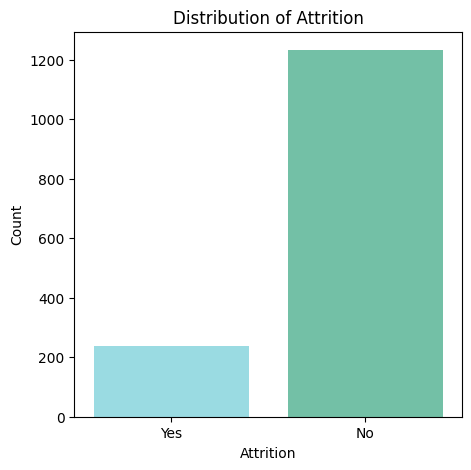

In [8]:
plt.figure(figsize=(5,5))
sns.countplot(data = df, x="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of Attrition")
plt.xlabel("Attrition")
plt.ylabel("Count")
plt.show()

237 employees have left the company while 1233 are still employed.

### 3.2.1 Demographic Features


#### Age

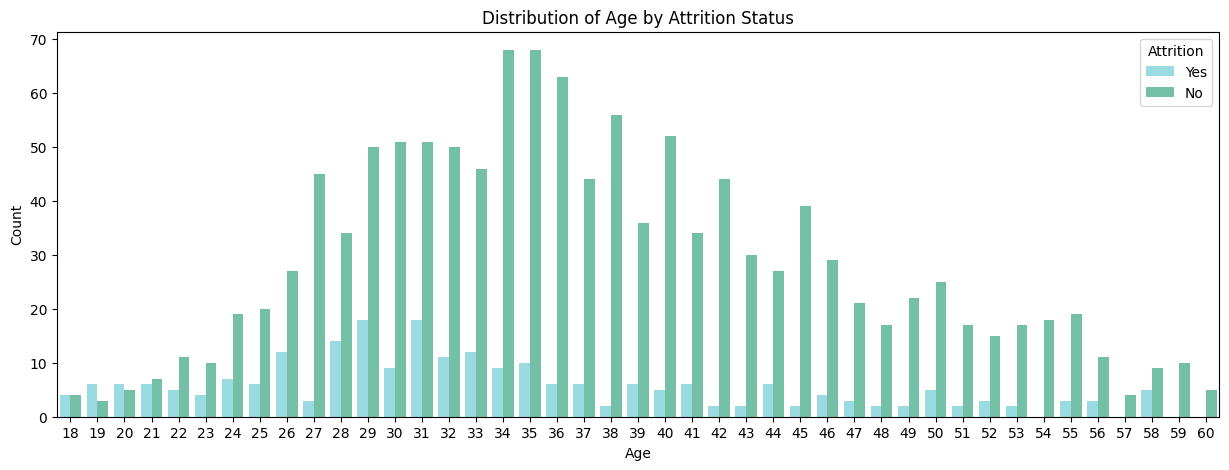

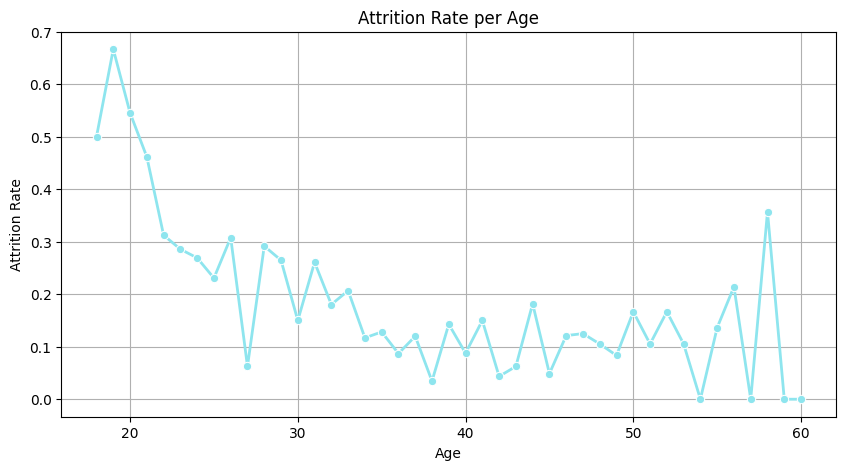

In [9]:
# Distribution of Age, compared by Attrition
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x="Age", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of Age by Attrition Status")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per Age
temp_df = df.copy()
temp_df['Attrition'] = temp_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
age_attrition_rate = temp_df.groupby('Age')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=age_attrition_rate.index, y=age_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per Age')
plt.xlabel('Age')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The first chart shows the distribution of employees' ages, categorized by attrition status (Yes/No). Most employees are aged between 30 and 40 with younger employees tending to leave more often.

2. The attrition rate plot indicates a higher attrition rate for younger employees (peaking around ages 18-22), which then decreases with age, stabilizing around mid-30s and beyond.

#### DistanceFromHome

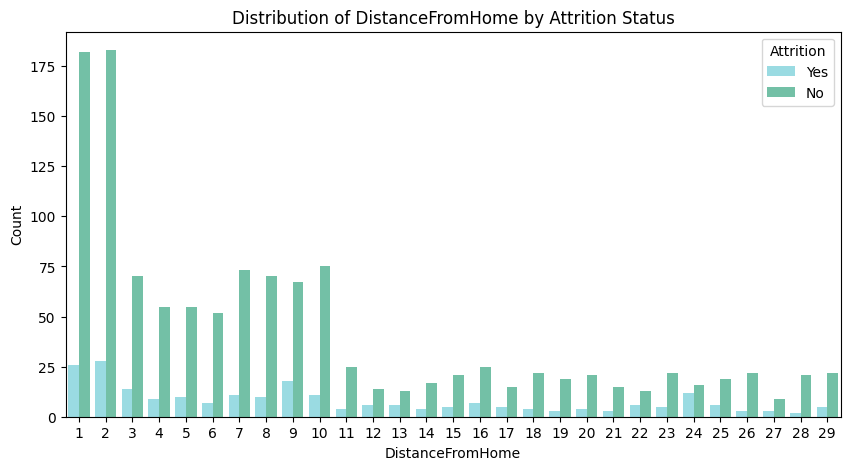

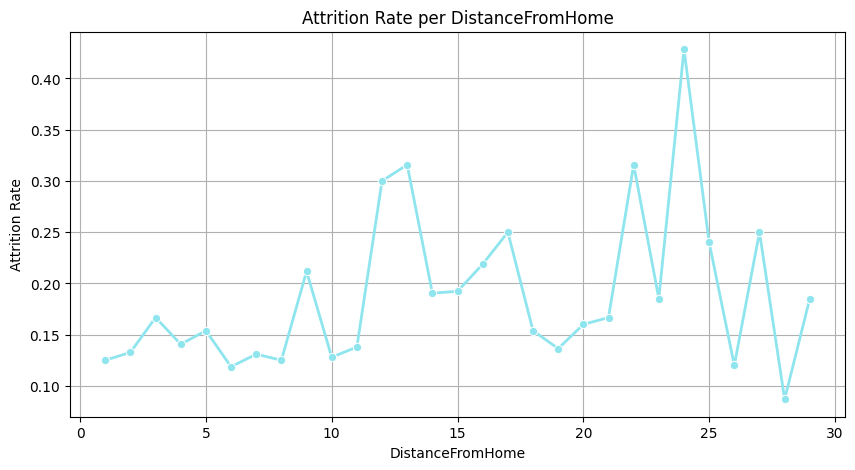

In [10]:
# Distribution of DistanceFromHome, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="DistanceFromHome", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of DistanceFromHome by Attrition Status")
plt.xlabel("DistanceFromHome")
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per DistanceFromHome
distance_attrition_rate = temp_df.groupby('DistanceFromHome')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=distance_attrition_rate.index, y=distance_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per DistanceFromHome')
plt.xlabel('DistanceFromHome')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The histogram shows that most employees live relatively close to their workplace. Attrition spreads across all distances here.

2. The attrition rate plot suggests that employees who live further away from work (around distance 23-25) experience higher attrition rates compared to those living closer.

#### Education

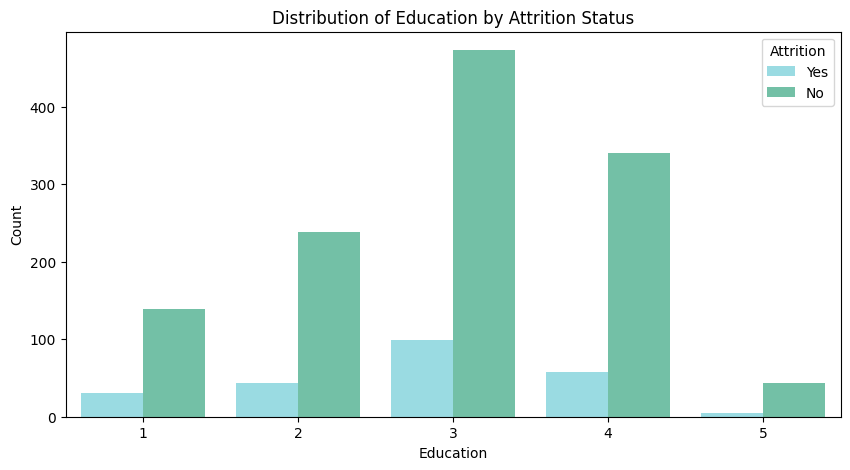

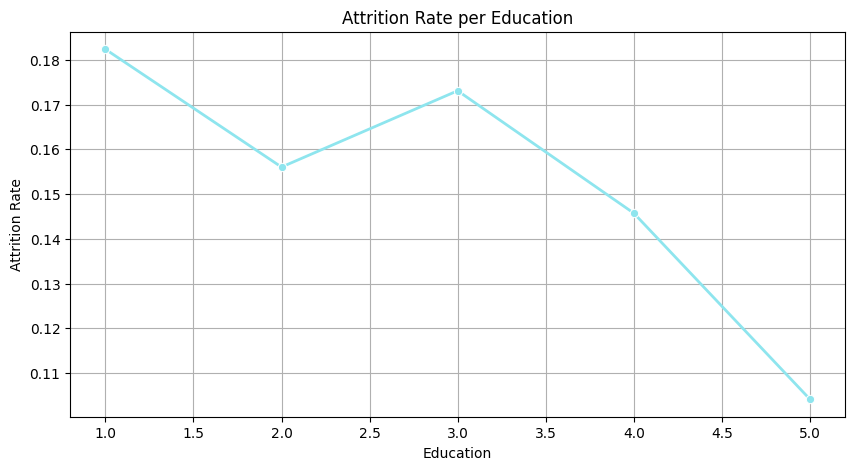

In [11]:
# Distribution of Education, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Education", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of Education by Attrition Status")
plt.xlabel("Education")
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per Education
education_attrition_rate = temp_df.groupby('Education')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=education_attrition_rate.index, y=education_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per Education')
plt.xlabel('Education')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The bar chart shows that most employees have an education level of 3 (which is a Bachelor's degree according to the dataset).

2. The attrition rate plot highlights a decreasing attrition in employees with higher education.

#### EducationField

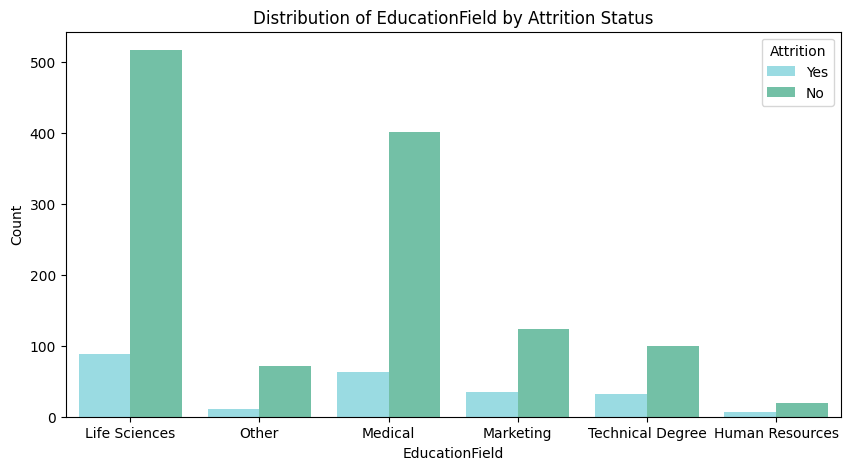

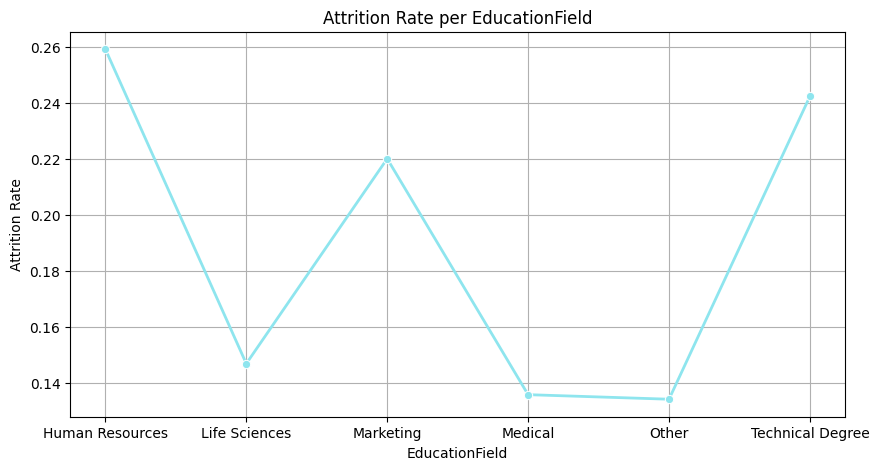

In [12]:
# Distribution of EducationField, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="EducationField", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of EducationField by Attrition Status")
plt.xlabel("EducationField")
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per EducationField
education_field_attrition_rate = temp_df.groupby('EducationField')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=education_field_attrition_rate.index, y=education_field_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per EducationField')
plt.xlabel('EducationField')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The first chart shows that most employees are from Life Sciences and Medical fields.

2. The attrition plot shows that employees working in Human Resources, Marketing and Technical Degrees are more likely to leave.

#### Gender

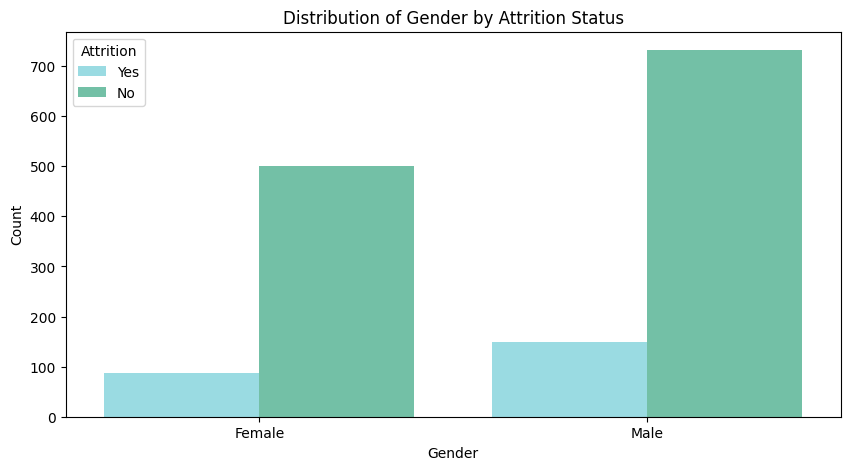

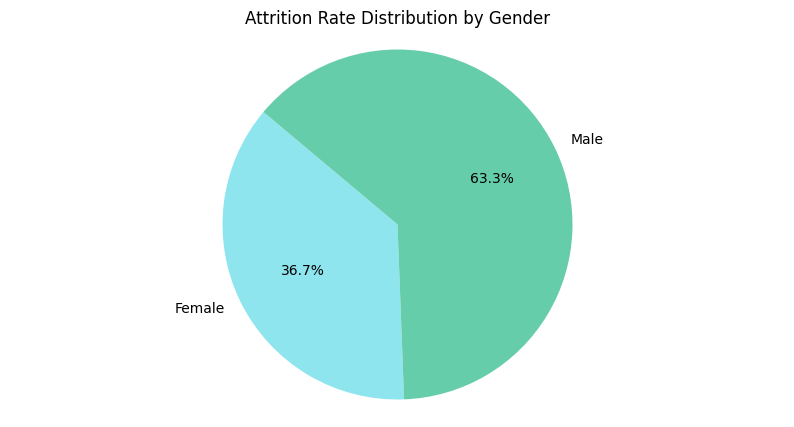

In [13]:
# Distribution of Gender, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Gender", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of Gender by Attrition Status")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per Gender
gender_attrition_counts = temp_df.groupby('Gender')['Attrition'].sum()
plt.figure(figsize=(10, 5))
colors = ['#8EE5EE', '#66CDAA']
plt.pie(gender_attrition_counts, labels=gender_attrition_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Attrition Rate Distribution by Gender')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()


1. The first chart shows that there are more male employees than female employees, but both experience attrition.

2. The pie chart shows that more men (63.3%) leave their jobs compared to women (36.7%)

#### MaritalStatus

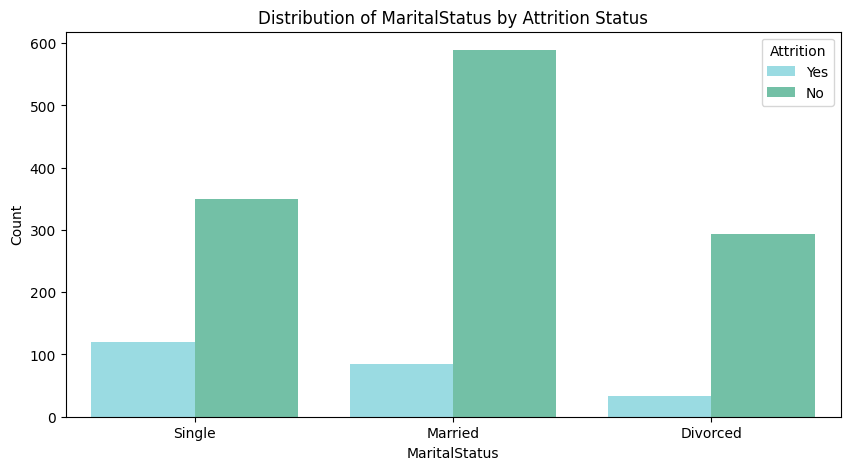

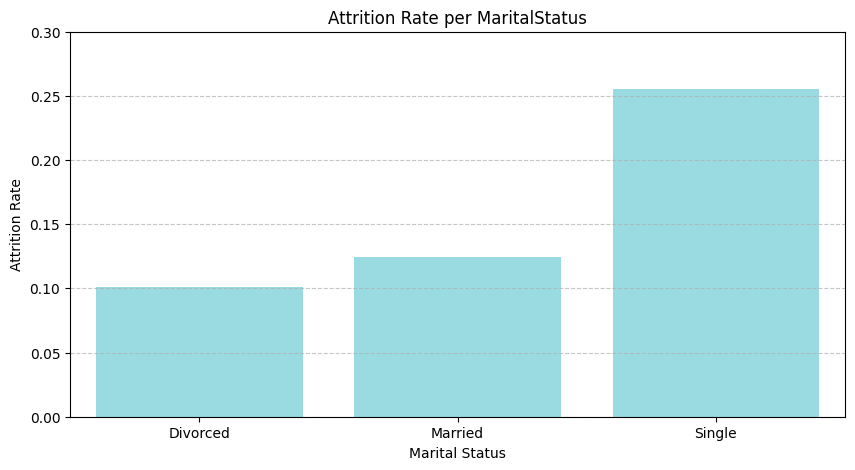

In [14]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="MaritalStatus", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of MaritalStatus by Attrition Status")
plt.xlabel("MaritalStatus")
plt.ylabel("Count")
plt.show()

temp_df = df.copy()
temp_df['Attrition'] = temp_df['Attrition'].map({'Yes': 1, 'No': 0})

# Calculate attrition rate per MaritalStatus
marital_status_attrition_rate = temp_df.groupby('MaritalStatus')['Attrition'].mean()

# Visualization of Attrition Rate per MaritalStatus as a bar chart
plt.figure(figsize=(10, 5))
sns.barplot(
    x=marital_status_attrition_rate.index,
    y=marital_status_attrition_rate.values,
    palette=['#8EE5EE']
)
plt.title('Attrition Rate per MaritalStatus')
plt.xlabel('Marital Status')
plt.ylabel('Attrition Rate')
plt.ylim(0, 0.3)  # Adjusting y-axis for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. The first plot displays the distribution of the marital status of the employees. The majority of employees are married followed by single and the least amount of employees are divorced.

2. When you look at the attrition rate you can see that single people have an attrition rate of approximately 26% whereas the married employees rate is at 12% and divorced employees only have a 10% attrition rate.

#### RelationshipSatisfaction

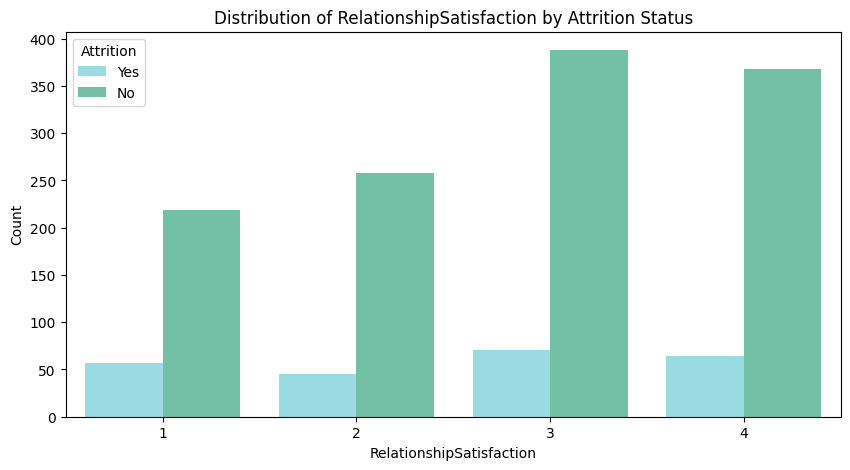

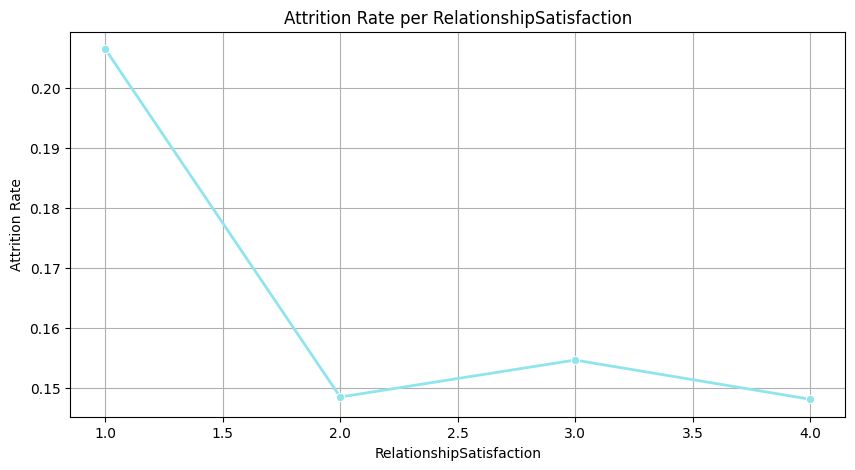

In [15]:
# Distribution of RelationshipSatisfaction, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="RelationshipSatisfaction", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of RelationshipSatisfaction by Attrition Status")
plt.xlabel("RelationshipSatisfaction")
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per RelationshipSatisfaction
relationship_satisfaction_attrition = temp_df.groupby('RelationshipSatisfaction')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=relationship_satisfaction_attrition.index, y=relationship_satisfaction_attrition.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per RelationshipSatisfaction')
plt.xlabel('RelationshipSatisfaction')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The stacked bar chart displays the employees relationship satisfactionlevels. Employees with a satisfaction level of 3 and 4 have the highest counts.Employees with a satisfaction level of 1 show the highest proportion of attrition compared to the other levels.

2. Attrition rate is highest for satisfaction level 1, exceeding 20%.
There is a significant drop in attrition rate at satisfaction level 2, falling below 15%.

#### Summary of Feature Impact on Attrition:

**High Impact:**
- Age
- DistanceFromHome
- MaritalStatus
- RelationshipStatus

**Moderate Impact:**
- Education
- EducationField

**Low Impact:**
- Gender


### 3.2.2 Job-Related Features

#### Department

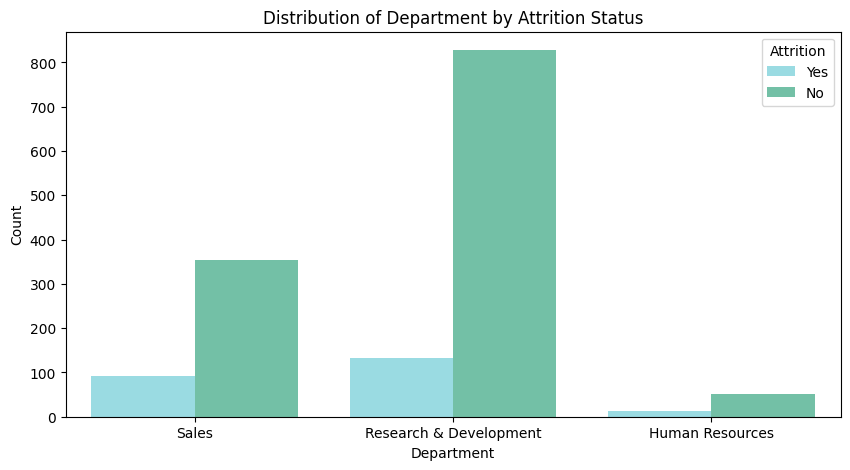

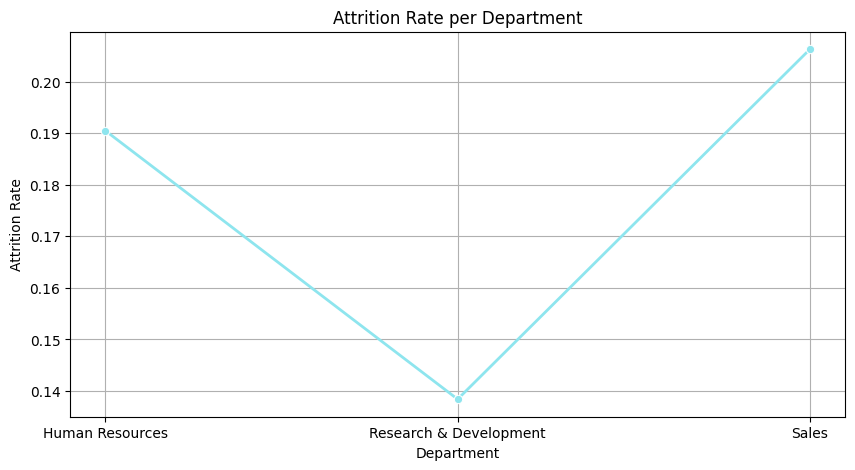

In [16]:
# Distribution of Department, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Department", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of Department by Attrition Status")
plt.xlabel("Department")
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per Department
department_attrition_rate = temp_df.groupby('Department')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=department_attrition_rate.index, y=department_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per Department')
plt.xlabel('Department')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The first chart indicates that the majority of employees belong to the Research & Development department, followed by Sales and Human Resources.

2. The attrition rate plot shows that Human Resources and Sales departments experience higher attrition, while Research & Development has the lowest attrition rate.

#### JobRole

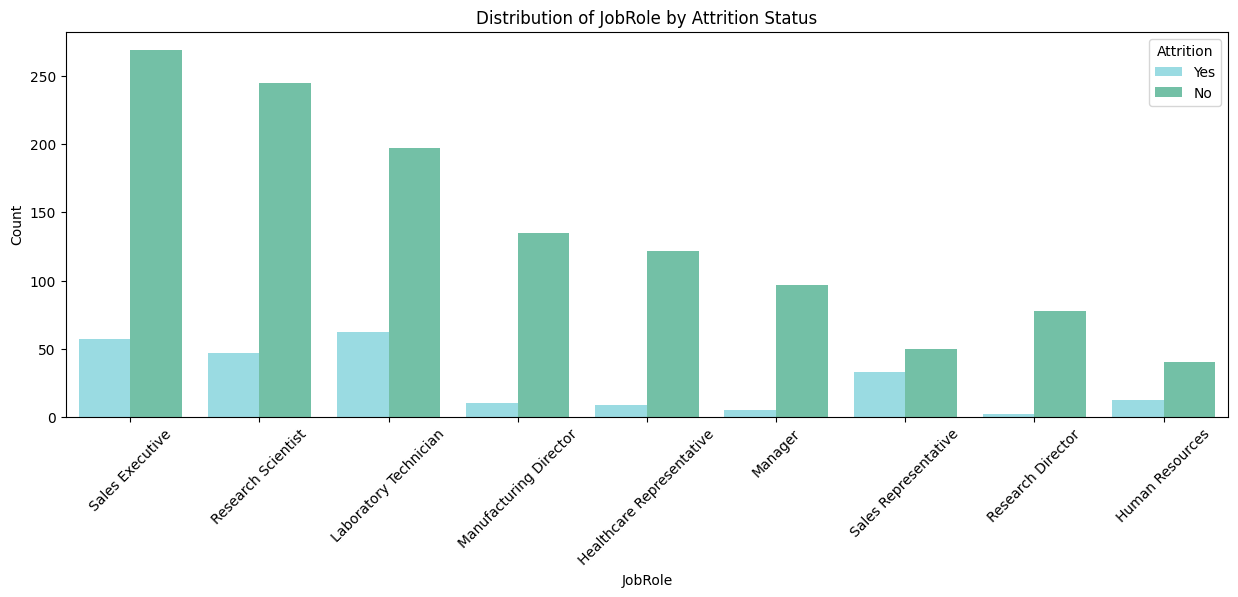

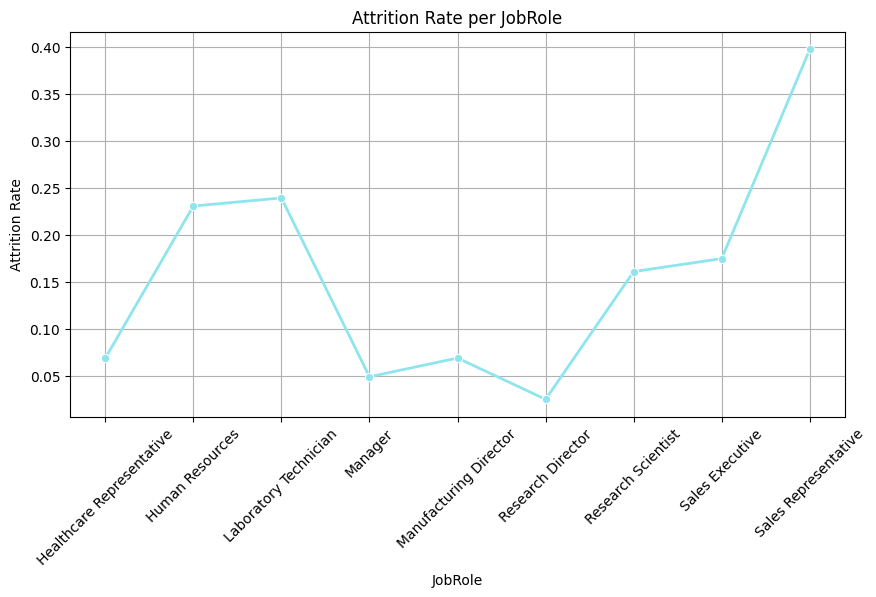

In [17]:
# Distribution of JobRole, compared by Attrition
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x="JobRole", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of JobRole by Attrition Status")
plt.xlabel("JobRole")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per JobRole
jobrole_attrition_rate = temp_df.groupby('JobRole')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=jobrole_attrition_rate.index, y=jobrole_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per JobRole')
plt.xlabel('JobRole')
plt.xticks(rotation=45)
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The first chart shows that Sales Executives (approximately 25%) and Research Scientists (around 23%) are the most common roles, while job roles like Research Director and Human Resources each make up less than 5% of the workforce.

2. The attrition rate plot indicates that Sales Representatives have the highest attrition rate, close to 40%, while Laboratory Technicians and Human Resources roles experience attrition at around 25%. Manufacturing Directors and Managers have relatively lower attrition rates, below 10%

#### JobLevel

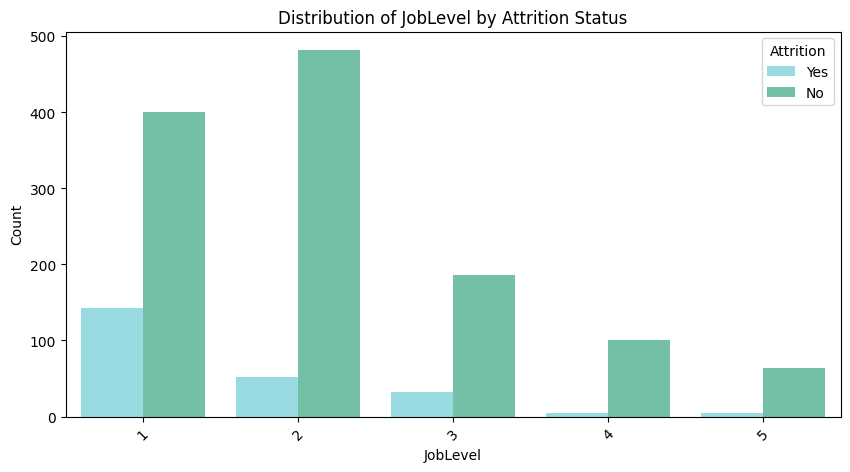

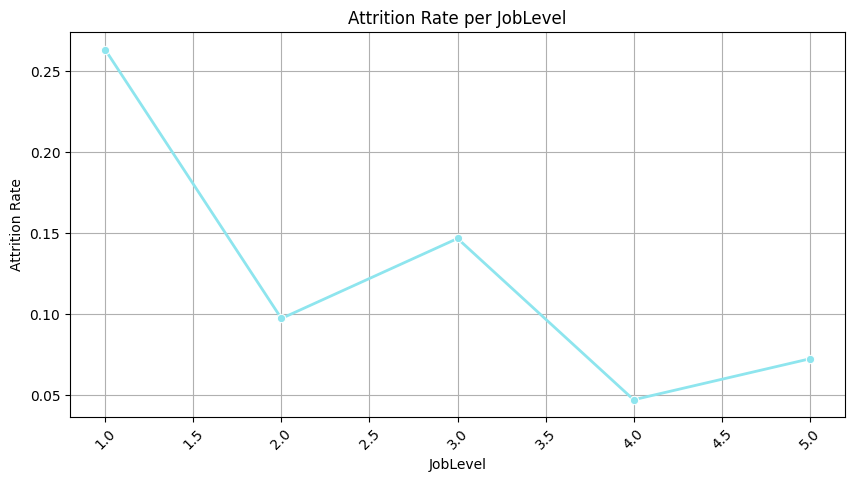

In [18]:
# Distribution of JobLevel, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="JobLevel", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of JobLevel by Attrition Status")
plt.xlabel("JobLevel")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per JobLevel
joblevel_attrition_rate = temp_df.groupby('JobLevel')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=joblevel_attrition_rate.index, y=joblevel_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per JobLevel')
plt.xlabel('JobLevel')
plt.xticks(rotation=45)
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The top plot shows the distribution of employees across different job levels, with attrition status represented by color. It indicates that attrition is most prevalent at job level 1, with decreasing counts as job levels increase.

2. The bottom plot shows the attrition rate per job level, showing that employees at job level 1 experience the highest attrition rate, which significantly drops at level 2 and fluctuates slightly in higher levels before reaching its lowest point at level 4.

#### JobInvolvement

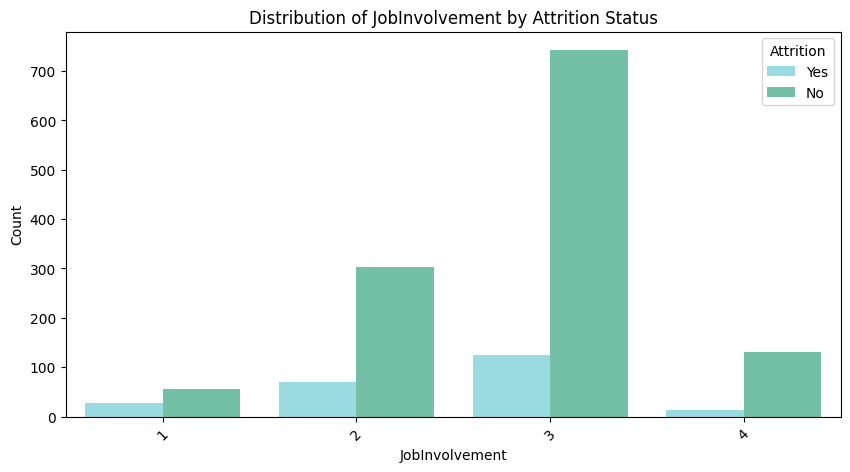

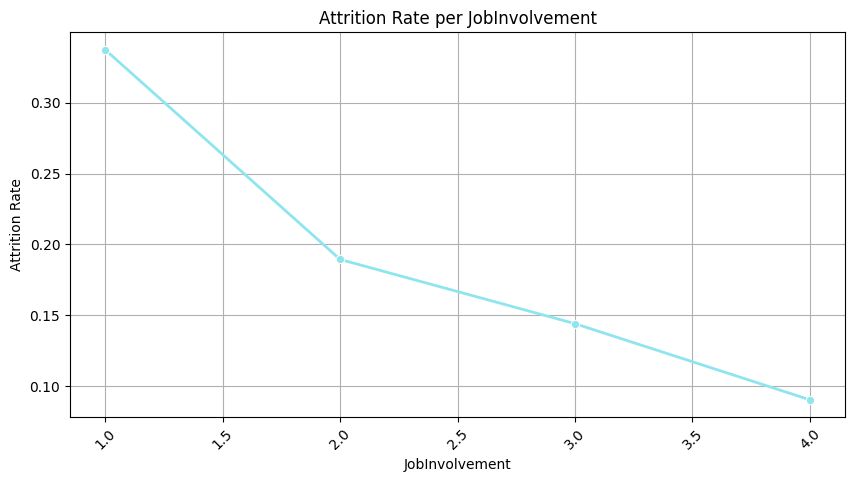

In [19]:
# Distribution of JobInvolvement, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="JobInvolvement", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of JobInvolvement by Attrition Status")
plt.xlabel("JobInvolvement")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per JobInvolvement
jobinvolvement_attrition_rate = temp_df.groupby('JobInvolvement')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=jobinvolvement_attrition_rate.index, y=jobinvolvement_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per JobInvolvement')
plt.xlabel('JobInvolvement')
plt.xticks(rotation=45)
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The first plot shows the distribution of employees across different job involvement levels, with attrition status represented by color. Most employees have a job involvement level of 3, and attrition is more common among those with lower involvement levels.

2. The line plot displays the attrition rate across job involvement levels, revealing a clear downward trend. Employees with the lowest job involvement (level 1) experience the highest attrition rate, while those with higher involvement are less likely to leave, with the lowest attrition observed at level 4.

#### StandardHours

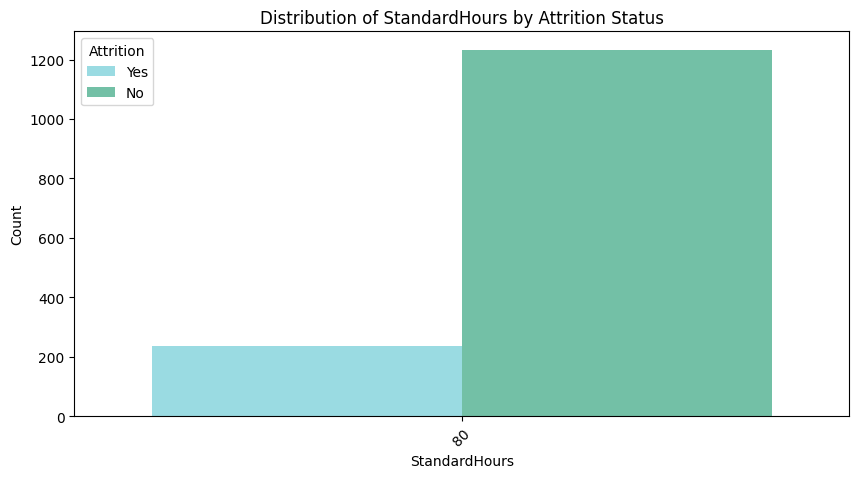

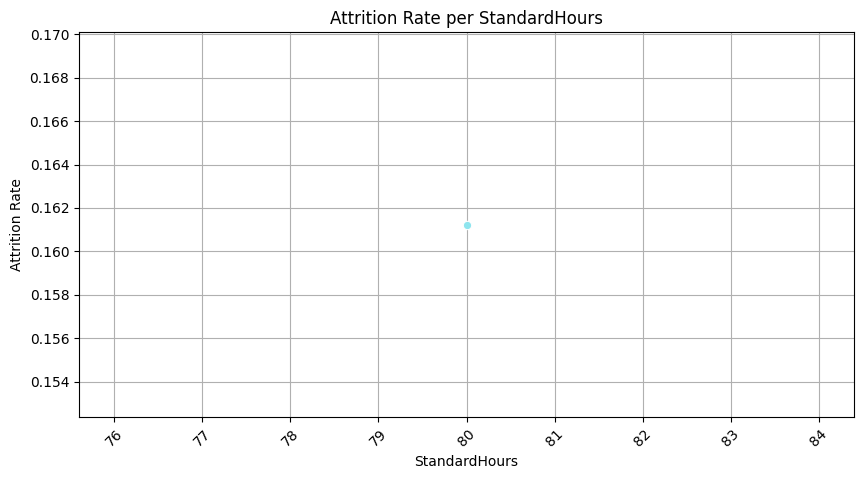

In [20]:
# Distribution of StandardHours, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="StandardHours", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of StandardHours by Attrition Status")
plt.xlabel("StandardHours")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per StandardHours
standardhours_attrition_rate = temp_df.groupby('StandardHours')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=standardhours_attrition_rate.index, y=standardhours_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per StandardHours')
plt.xlabel('StandardHours')
plt.xticks(rotation=45)
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

All values in the dataset in the column StandardHours are 80.

#### TotalWorkingYears

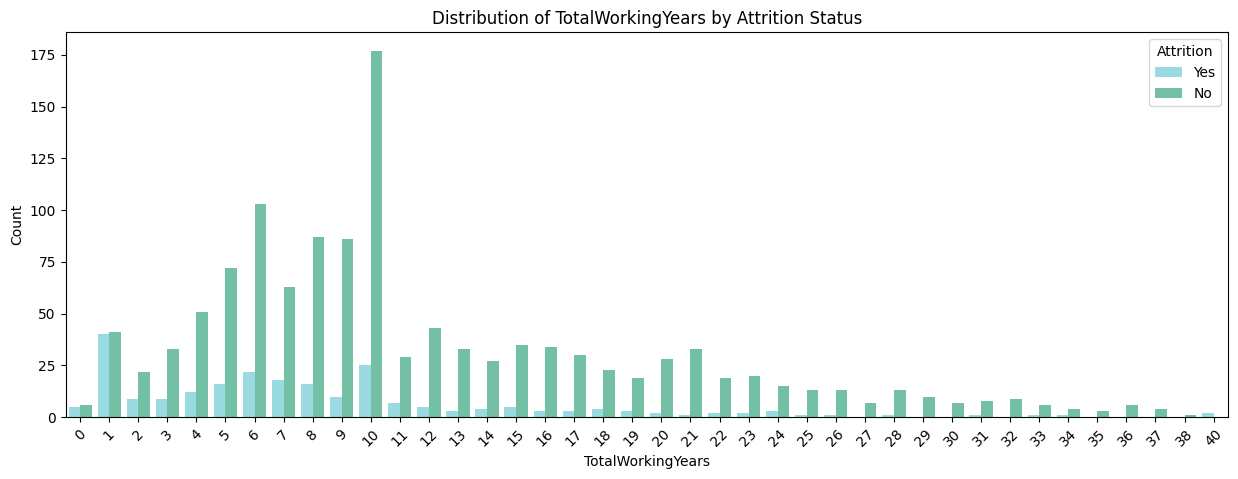

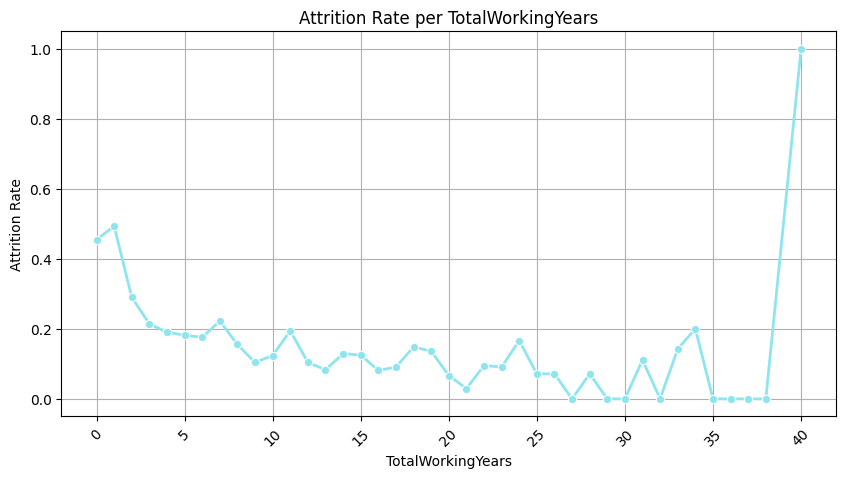

In [21]:
# Distribution of TotalWorkingYears, compared by Attrition
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x="TotalWorkingYears", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of TotalWorkingYears by Attrition Status")
plt.xlabel("TotalWorkingYears")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per TotalWorkingYears
totalworkinyears_attrition_rate = temp_df.groupby('TotalWorkingYears')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=totalworkinyears_attrition_rate.index, y=totalworkinyears_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per TotalWorkingYears')
plt.xlabel('TotalWorkingYears')
plt.xticks(rotation=45)
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The first plot shows the distribution of employees based on their total working years, categorized by attrition status. Most employees have between 5 to 10 years of experience, with a noticeable spike at year 10. Attrition occurs across various experience levels but appears more concentrated among employees with fewer years

2. This plot presents the attrition rate by total working years, showing a high attrition rate among employees with very low experience, which gradually decreases over time but spikes again for those with 40 years of experience

#### YearsInCurrentRole

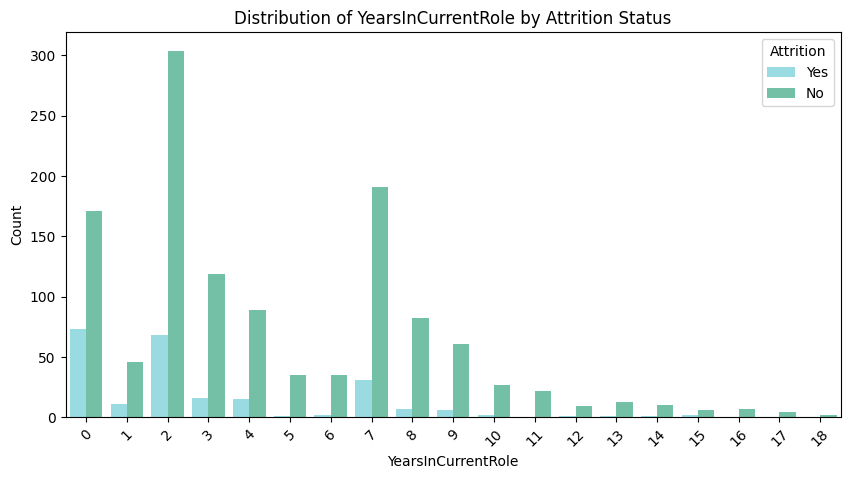

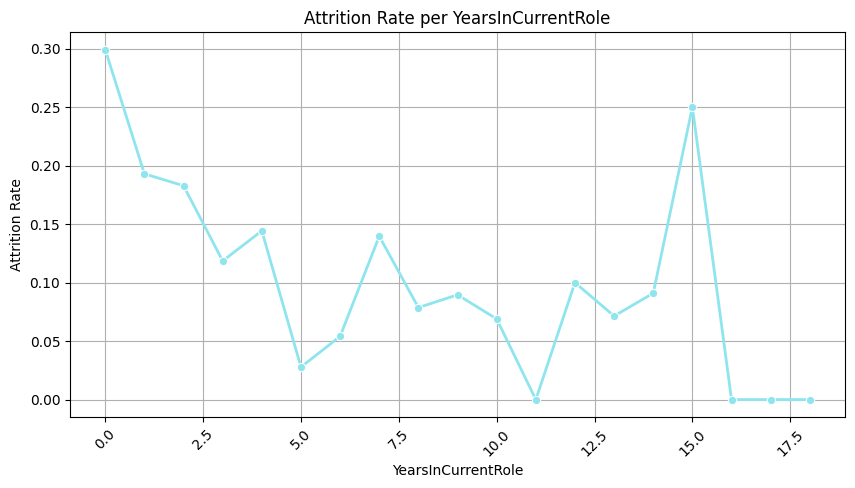

In [22]:
# Distribution of YearsInCurrentRole, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="YearsInCurrentRole", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of YearsInCurrentRole by Attrition Status")
plt.xlabel("YearsInCurrentRole")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per YearsInCurrentRole
yearsincurrentrole_attrition_rate = temp_df.groupby('YearsInCurrentRole')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=yearsincurrentrole_attrition_rate.index, y=yearsincurrentrole_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per YearsInCurrentRole')
plt.xlabel('YearsInCurrentRole')
plt.xticks(rotation=45)
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The first plot illustrates the distribution of employees based on their years in their current role. Most employees have been in their role for 0, 2, and 7 years, with attrition being relatively higher in the early years.

2. The bottom plot indicates that attrition is highest for employees with < 1 year in their current role and decreases over time, although some fluctuations are observed, especially after 15 years

#### YearsWithCurrentManager

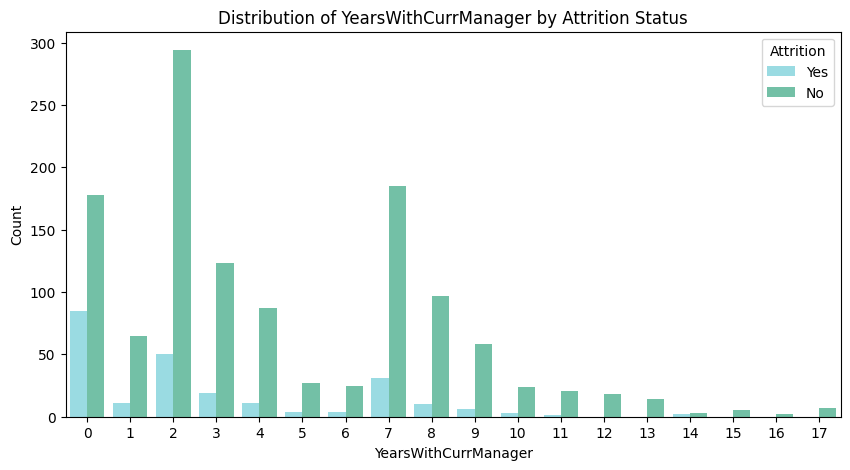

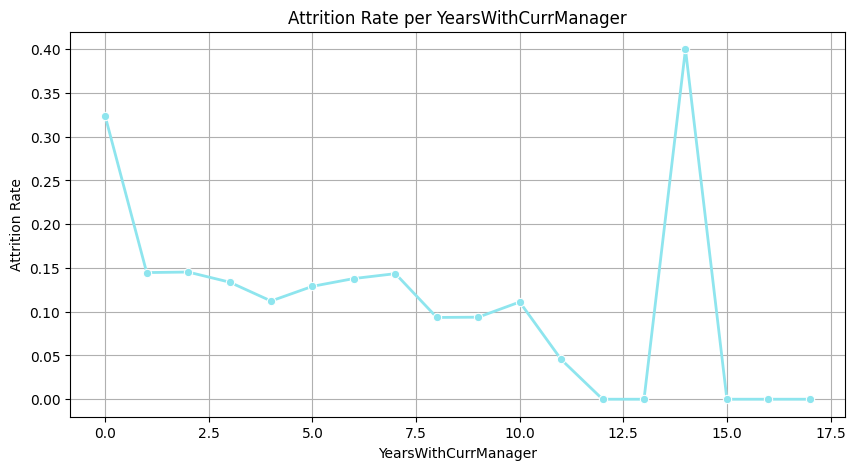

In [23]:
# Distribution of YearsWithCurrManager, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="YearsWithCurrManager", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of YearsWithCurrManager by Attrition Status")
plt.xlabel("YearsWithCurrManager")
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per YearsWithCurrManager
years_curr_manager_attrition_rate = temp_df.groupby('YearsWithCurrManager')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=years_curr_manager_attrition_rate.index, y=years_curr_manager_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per YearsWithCurrManager')
plt.xlabel('YearsWithCurrManager')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The top plot displays the distribution of employees based on how many years they have worked with their current manager. A significant number of employees have been with their manager for 0, 2, and 7 years, with noticeable attrition occurring in the early years.

2. The bottom plot shows a downward trend in attrition rates with increasing years under the same manager, although there is a notable spike at around 15 years before dropping again

#### NumCompaniesWorked

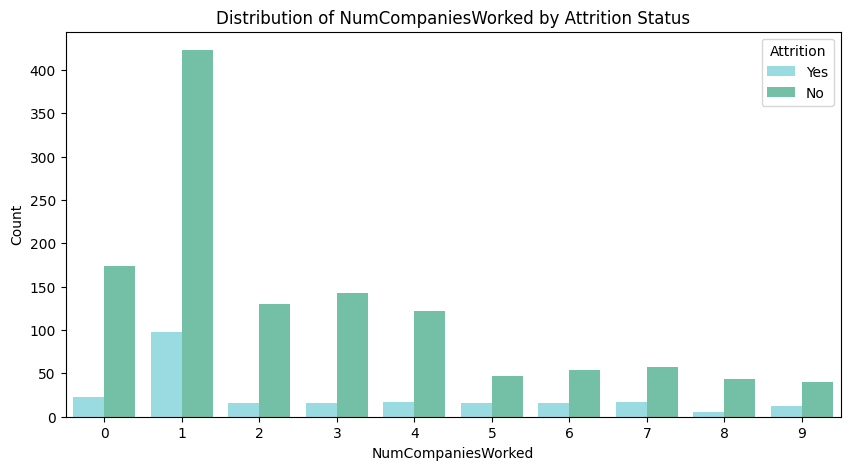

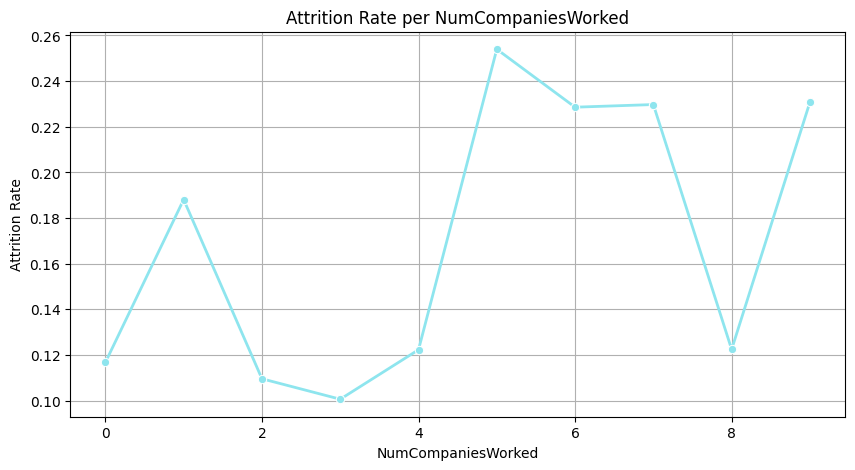

In [24]:
# Distribution of NumCompaniesWorked, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="NumCompaniesWorked", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of NumCompaniesWorked by Attrition Status")
plt.xlabel("NumCompaniesWorked")
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per NumCompaniesWorked
num_companies_attrition_rate = temp_df.groupby('NumCompaniesWorked')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=num_companies_attrition_rate.index, y=num_companies_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per NumCompaniesWorked')
plt.xlabel('NumCompaniesWorked')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The histogram suggests that about 35% of employees have only worked at one other company before their current job, while 20% have no prior experience.

2. The attrition rate plot shows that employees with 0 to 1 previous companies have an attrition rate at around 12-18%. The highest attrition rate can be seen in employees with 5+ prior jobs at 25%.

#### PerformanceRating

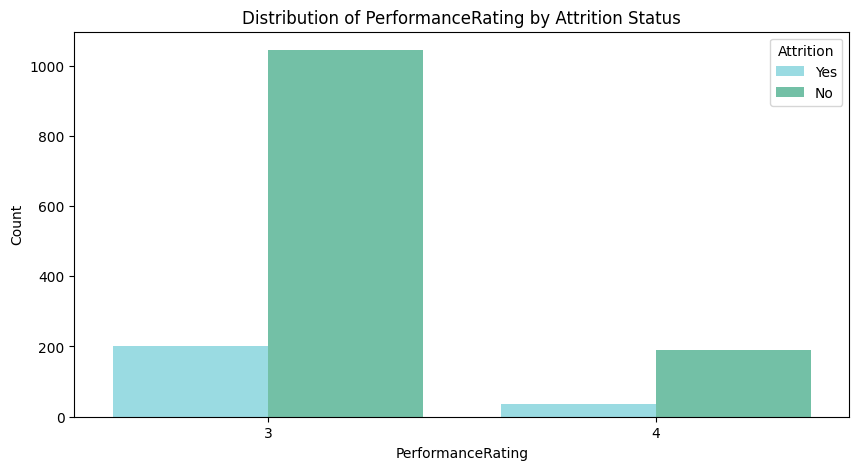

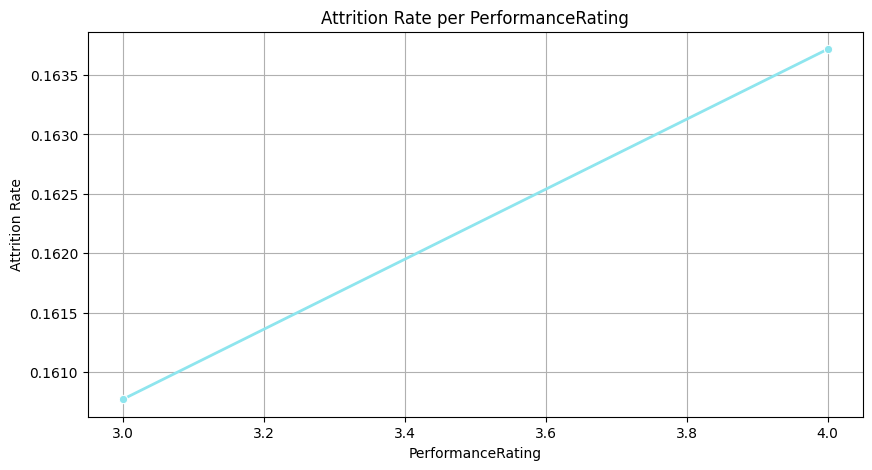

In [25]:
# Distribution of PerformanceRating, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="PerformanceRating", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of PerformanceRating by Attrition Status")
plt.xlabel("PerformanceRating")
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per PerformanceRating
performance_attrition_rate = temp_df.groupby('PerformanceRating')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=performance_attrition_rate.index, y=performance_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per PerformanceRating')
plt.xlabel('PerformanceRating')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. In the first chart you can see that no employees have a rating below 3. (The rating goes from 1-4). Approximately 85% of employees have a performance rating of 3, while around 15% have a rating of 4.

2. The attrition rate only slightly increases with performance ratings, from 16.1% at a rating of 3 to around 16.4% at a rating of 4. This suggests that performance rating has a minimal impact on attrition.

#### TrainingTimesLastYear

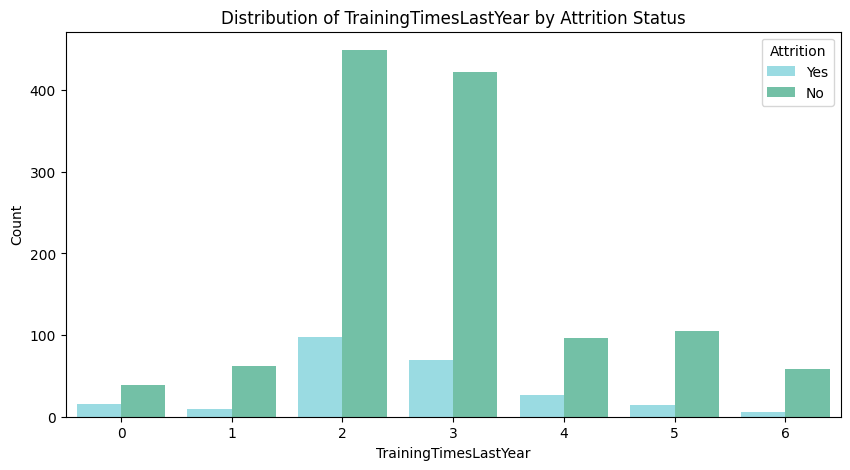

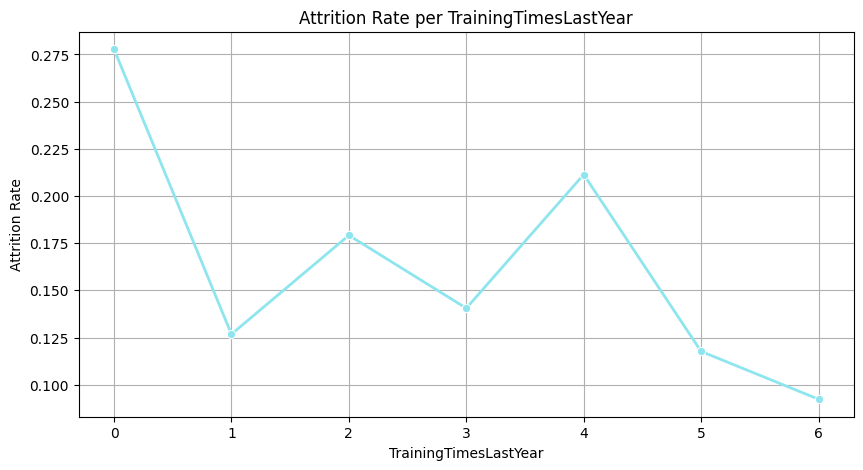

In [26]:
# Distribution of TrainingTimesLastYear, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="TrainingTimesLastYear", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of TrainingTimesLastYear by Attrition Status")
plt.xlabel("TrainingTimesLastYear")
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per TrainingTimesLastYear
training_times_attrition_rate = temp_df.groupby('TrainingTimesLastYear')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=training_times_attrition_rate.index, y=training_times_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per TrainingTimesLastYear')
plt.xlabel('TrainingTimesLastYear')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The first chart visualizes the number of training sessions employees attended in the last year and their attrition status. Most employees (around 60%) received training 2 to 3 times, while approximately 10% received no training at all.

2. The attrition rate plot shows that employees who did not receive any training have the highest attrition rate of around 28%. Whereas those with 6 training sessions show the lowest attrition rate at about 10%.

#### YearsSinceLastPromotion

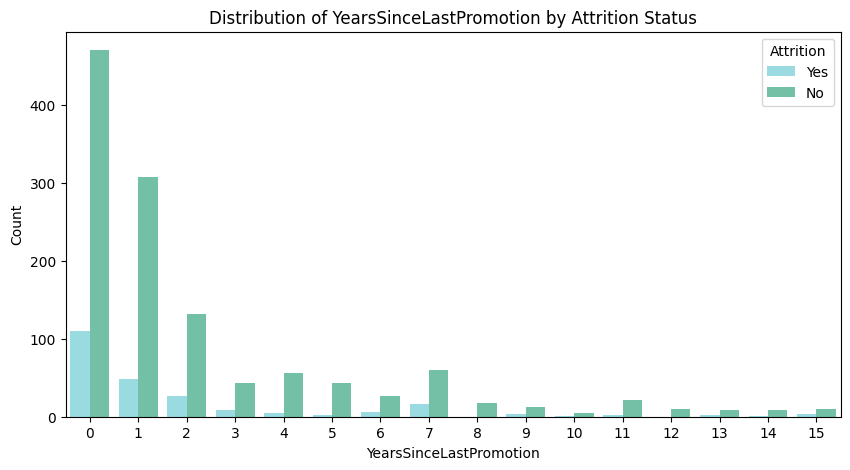

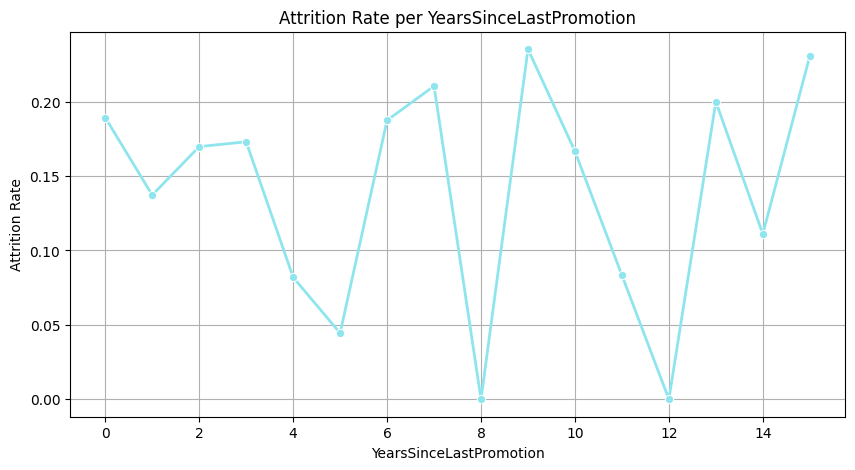

In [27]:
# Distribution of YearsSinceLastPromotion, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="YearsSinceLastPromotion", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of YearsSinceLastPromotion by Attrition Status")
plt.xlabel("YearsSinceLastPromotion")
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per YearsSinceLastPromotion
years_since_promotion_attrition_rate = temp_df.groupby('YearsSinceLastPromotion')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=years_since_promotion_attrition_rate.index, y=years_since_promotion_attrition_rate.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per YearsSinceLastPromotion')
plt.xlabel('YearsSinceLastPromotion')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()


1. The first chart presents data on the number of years since an employee’s last promotion and their attrition status. Approximately 45% of employees have not been promoted in the last year, while about 20% were promoted within the past 1-2 years.

2. The attrition rate plot shows that employees with no recent promotions have an attrition rate of around 20%, while those who have not been promoted for 6-7 years experience an even higher attrition rate of 22%. There is an outlier at 8 years with no sign of attrition. this could be an anomaly.

#### Summary of Feature Impact on Attrition:

**High Impact:**
- JobRole
- JobLevel
- JobInvolvement
- YearsSinceLastPromotion
- Department

**Moderate Impact:**
- TotalWorkingYears
- YearsInCurrentRole
- YearsWithCurrManager
- TrainingTimesLastYear
- NumCompaniesWorked

**Low Impact:**
- PerformanceRating
- StandardHours


### 3.2.3 Compensation Features




#### MonthlyRate, MonthlyIncome

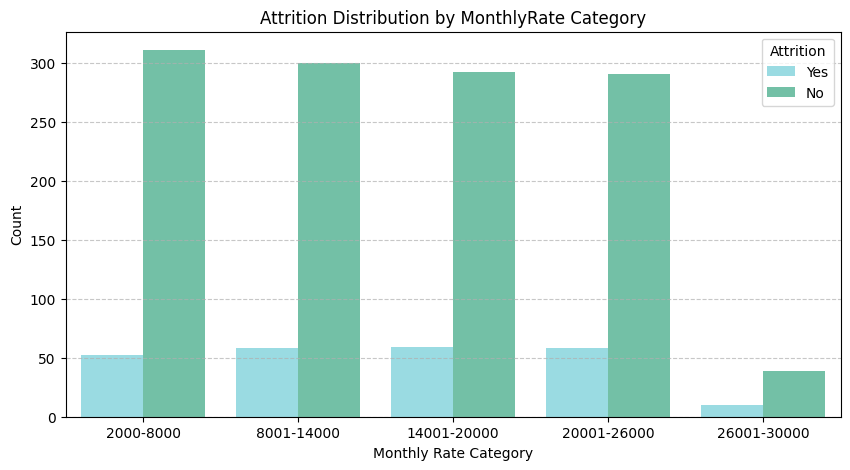

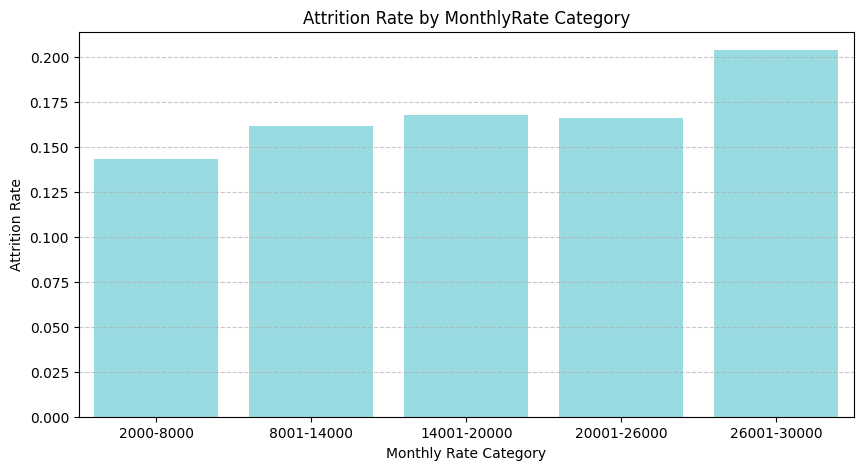

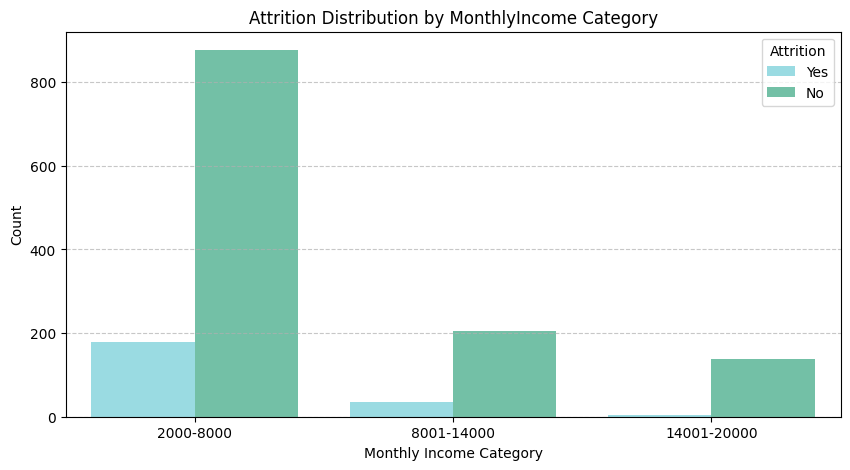

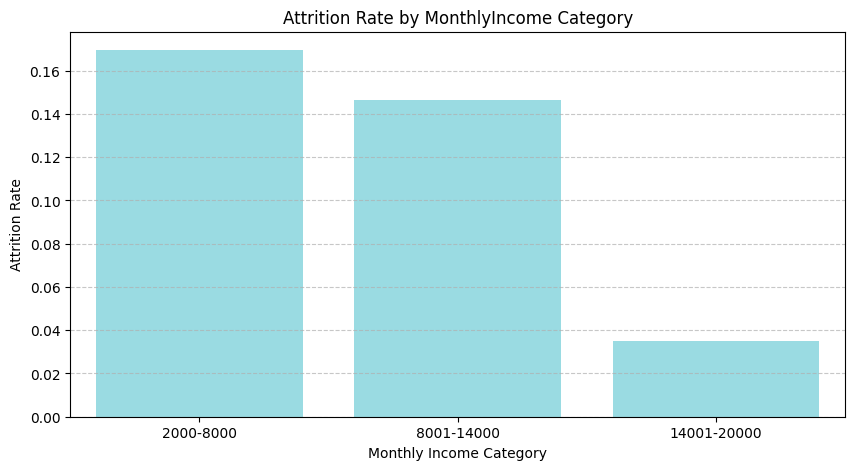

In [28]:
# Convert Attrition to numeric: 'Yes' = 1, 'No' = 0
temp_df = df.copy()
temp_df['AttritionNumeric'] = temp_df['Attrition'].map({'Yes': 1, 'No': 0})


# Define bins and labels for MonthlyRate
bins_rate = [2000, 8000, 14000, 20000, 26000, 30000]
labels_rate = ['2000-8000', '8001-14000', '14001-20000', '20001-26000', '26001-30000']

# Create a new column with categorized MonthlyRate
temp_df['MonthlyRateCategory'] = pd.cut(df['MonthlyRate'], bins=bins_rate, labels=labels_rate, right=False)

# Plot Attrition Distribution by MonthlyRate Category
plt.figure(figsize=(10, 5))
sns.countplot(data=temp_df, x='MonthlyRateCategory', hue='Attrition', palette=['#8EE5EE', "#66CDAA"])
plt.title("Attrition Distribution by MonthlyRate Category")
plt.xlabel("Monthly Rate Category")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Group by MonthlyRateCategory and calculate attrition rate
attrition_rate_by_category = temp_df.groupby('MonthlyRateCategory')['AttritionNumeric'].mean()

# Plot Attrition Rate by MonthlyRate Category
plt.figure(figsize=(10, 5))
sns.barplot(x=attrition_rate_by_category.index, y=attrition_rate_by_category.values, palette=['#8EE5EE'])
plt.title("Attrition Rate by MonthlyRate Category")
plt.xlabel("Monthly Rate Category")
plt.ylabel("Attrition Rate")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#---
# Define bins and labels for MonthlyIncome
bins_income = [2000, 8000, 14000, 20000]
labels_income = ['2000-8000', '8001-14000', '14001-20000']

# Create a new column with categorized MonthlyIncome
temp_df['MonthlyIncomeCategory'] = pd.cut(temp_df['MonthlyIncome'], bins=bins_income, labels=labels_income, right=False)

# Plot Attrition Distribution by MonthlyIncome Category
plt.figure(figsize=(10, 5))
sns.countplot(data=temp_df, x='MonthlyIncomeCategory', hue='Attrition', palette=['#8EE5EE', "#66CDAA"])
plt.title("Attrition Distribution by MonthlyIncome Category")
plt.xlabel("Monthly Income Category")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Group by MonthlyIncomeCategory and calculate attrition rate
attrition_rate_by_category = temp_df.groupby('MonthlyIncomeCategory')['AttritionNumeric'].mean()

# Plot Attrition Rate by MonthlyIncome Category
plt.figure(figsize=(10, 5))
sns.barplot(x=attrition_rate_by_category.index, y=attrition_rate_by_category.values, palette=['#8EE5EE'])
plt.title("Attrition Rate by MonthlyIncome Category")
plt.xlabel("Monthly Income Category")
plt.ylabel("Attrition Rate")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. The first chart shows the distribution of employees across different monthly rate categories and their attrition status. To simplify visualization, we created salary bins to avoid clutter. Most employees fall within the salary ranges of 2000-8000, 8001-14000, 14001-20000, and 20001-26000, with relatively equal distributions across these categories.

2. The attrition rate plot shows that attrition rates are fairly consistent across most income groups, ranging between 14% and 17%, except for the highest income category (26001-30000), which shows a significantly higher attrition rate of over 20%.

3. The third chart displays the distribution by monhtly income. Most of the employees fall within the 2000-8000 income range.

4. The attrition plot indicates that employees earning between 2000-8000 have the highest attrition rate, around 16%. Attrition drops sharply for people earning between 14001-20000 to below 5%.

#### PercentSalaryHike

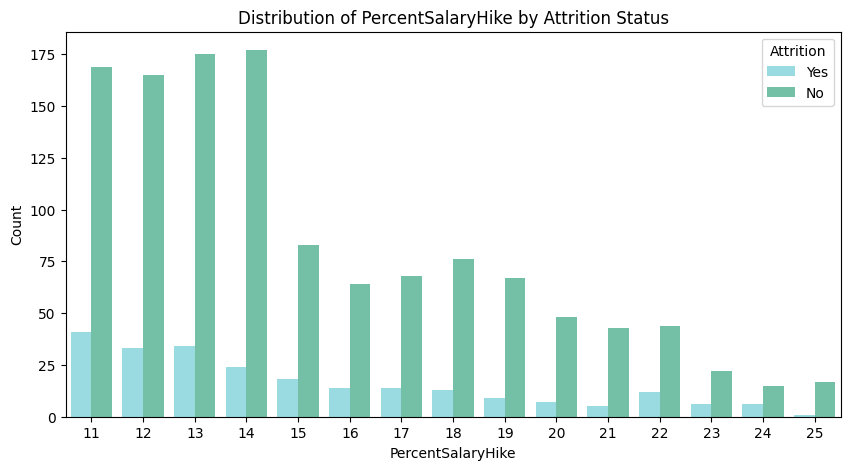

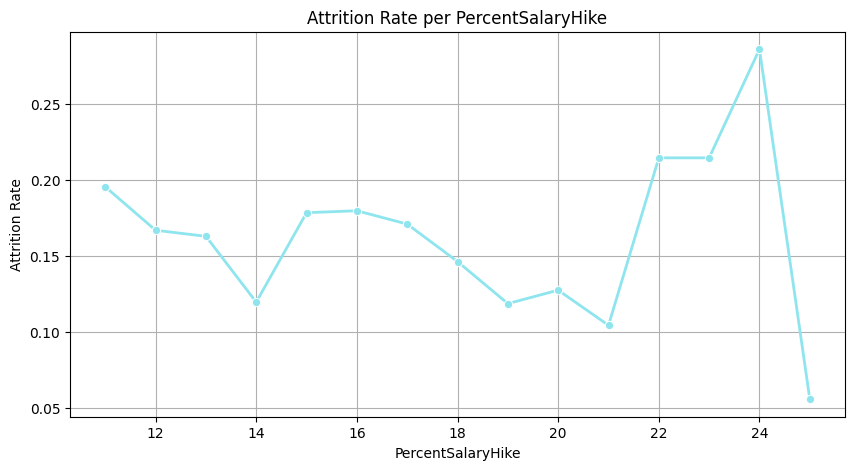

In [29]:
# Distribution of PercentSalaryHike, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="PercentSalaryHike", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of PercentSalaryHike by Attrition Status")
plt.xlabel("PercentSalaryHike")
plt.ylabel("Count")
plt.show()

# Distribution of AttritionRate per PercentSalaryHike
temp_df = df.copy()
temp_df['Attrition'] = temp_df['Attrition'].map({'Yes': 1, 'No': 0})

percent_salary_hike_attrition = temp_df.groupby('PercentSalaryHike')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=percent_salary_hike_attrition.index, y=percent_salary_hike_attrition.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per PercentSalaryHike')
plt.xlabel('PercentSalaryHike')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The first chart shows the distribution of salary hikes. Most employees received salary hikes in the range of 11-14%, while fewer received higher increases up to 25%

2. The attrition rate plot shows that employees with lower salary hikes (11-13%) have higher attrition rates, around 18-20%, whereas those receiving salary hikes around 14-20% experience lower attrition, at approximately 10-15%. However, attrition spikes again at higher salary hikes (24%) to around 27%, which may indicate dissatisfaction despite a raise.

#### StockOptionLevel

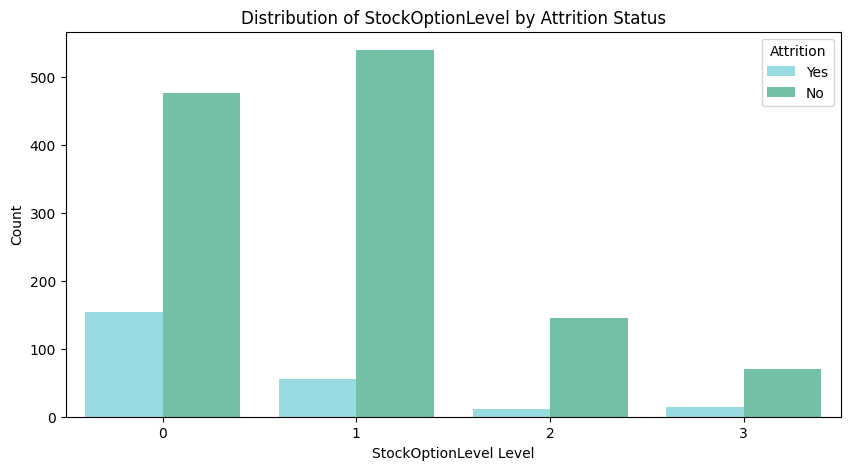

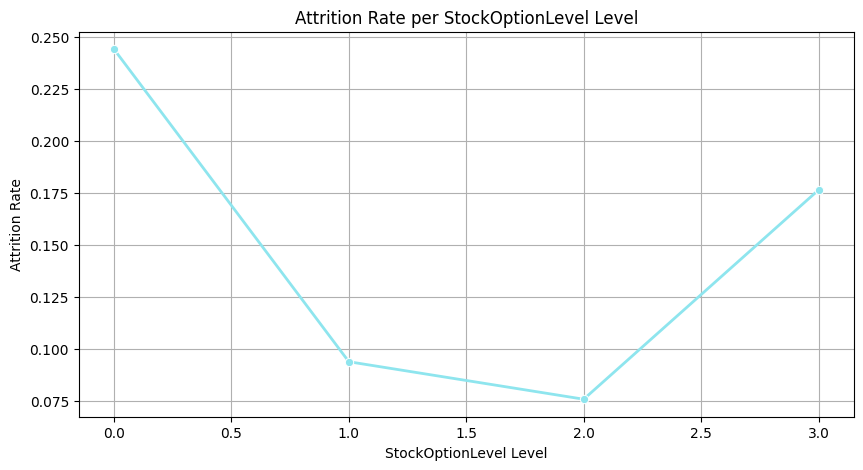

In [30]:
# Distribution of StockOptionLevel, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="StockOptionLevel", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of StockOptionLevel by Attrition Status")
plt.xlabel("StockOptionLevel Level")
plt.ylabel("Count")
plt.show()

# Distribution of Attrition Rate per StockOptionLevel
stock_option_attrition = temp_df.groupby('StockOptionLevel')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=stock_option_attrition.index, y=stock_option_attrition.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per StockOptionLevel Level')
plt.xlabel('StockOptionLevel Level')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()


#### Summary of Feature Impact on Attrition:

**High Impact:**
- MonthlyIncome

**Moderate Impact:**
- MonthlyRate
- PercentSalaryHike

### 3.2.4 Work-Life-Balance Features


#### BusinessTravel

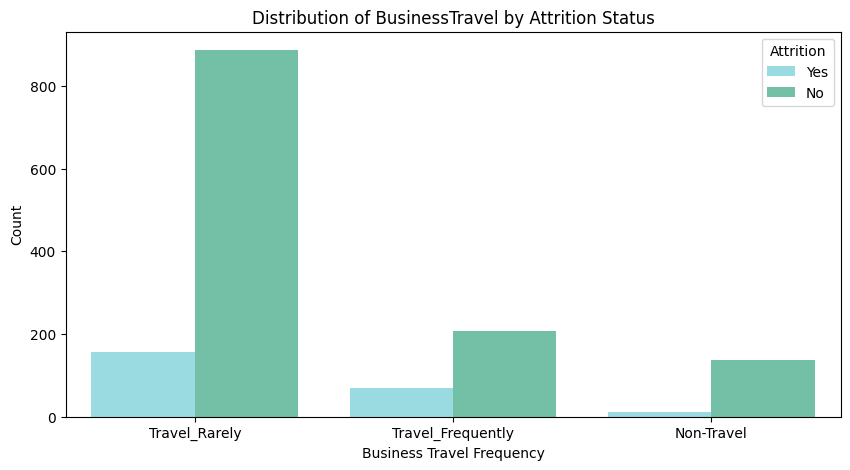

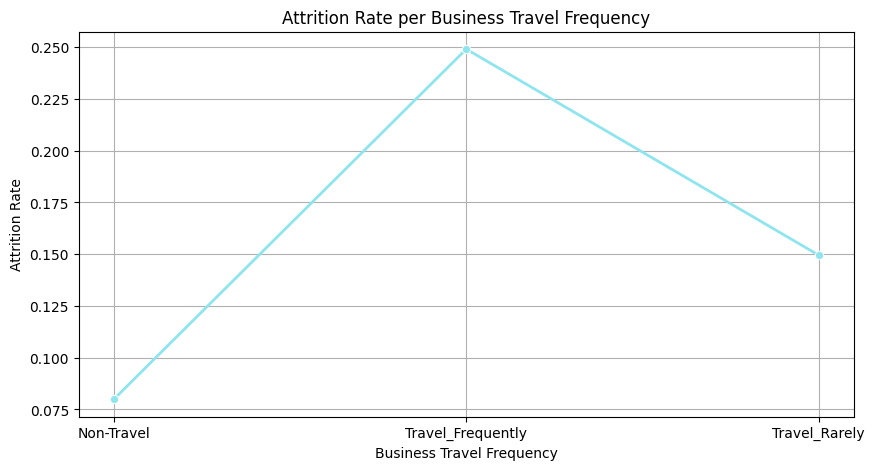

In [31]:
# Distribution of BusinessTravel, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="BusinessTravel", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of BusinessTravel by Attrition Status")
plt.xlabel("Business Travel Frequency")
plt.ylabel("Count")
plt.show()

# Distribution of Attrition Rate per BusinessTravel
business_travel_attrition = temp_df.groupby('BusinessTravel')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=business_travel_attrition.index, y=business_travel_attrition.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per Business Travel Frequency')
plt.xlabel('Business Travel Frequency')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The first chart shows that most employees travel rarely, with a smaller group traveling frequently or not at all. Employees who travel rarely make up the largest group, with over 900 employees, while about 250 employees travel frequently, and less than 150 do not travel.

2. The attrition rate plot reveals that employees who travel frequently have the highest attrition rate, at 25%, compared to those who travel rarely (15%) and those who do not travel (8%).

#### EnvironmentSatisfaction

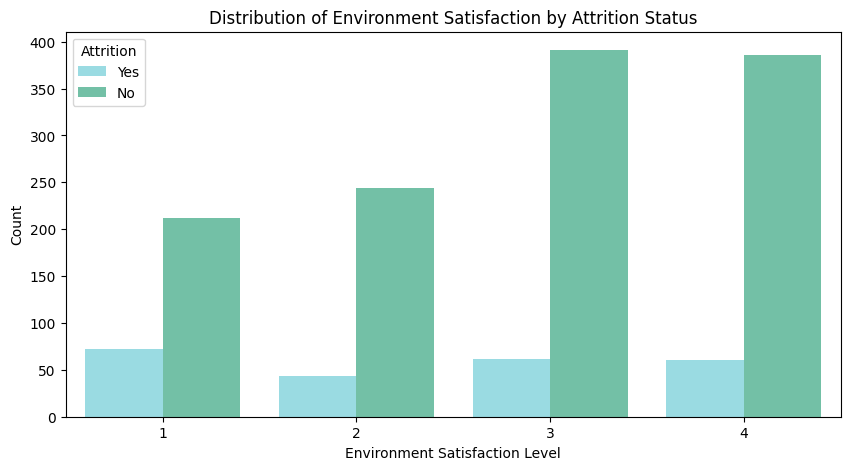

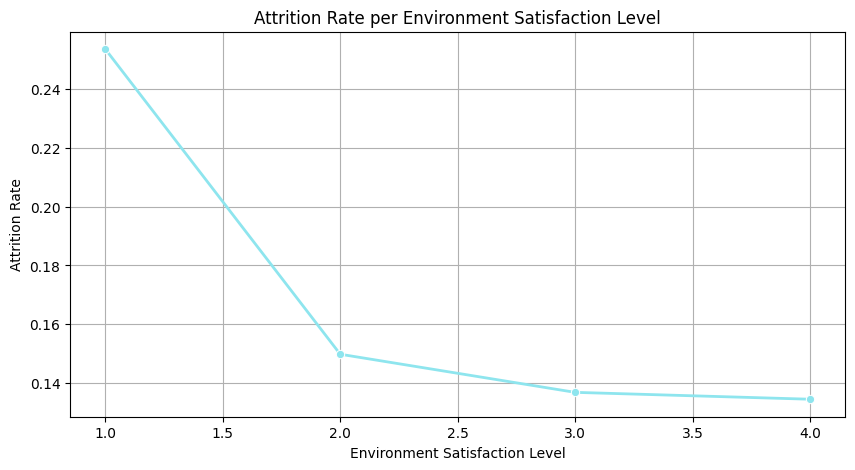

In [32]:
# Distribution of EnvironmentSatisfaction, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="EnvironmentSatisfaction", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of Environment Satisfaction by Attrition Status")
plt.xlabel("Environment Satisfaction Level")
plt.ylabel("Count")
plt.show()

# Distribution of Attrition Rate per EnvironmentSatisfaction
env_satisfaction_attrition = temp_df.groupby('EnvironmentSatisfaction')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=env_satisfaction_attrition.index, y=env_satisfaction_attrition.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per Environment Satisfaction Level')
plt.xlabel('Environment Satisfaction Level')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The first chart shows that the largest group of employees rated their satisfaction as level 3 or 4, with around 400 employees each, while lower satisfaction levels (1 and 2) have fewer employees.

2. The attrition rate plot shows a clear trend: employees with the lowest satisfaction level (1) experience the highest attrition rate, at around 25%, which decreases to about 14% for higher satisfaction levels.

#### JobSatisfaction

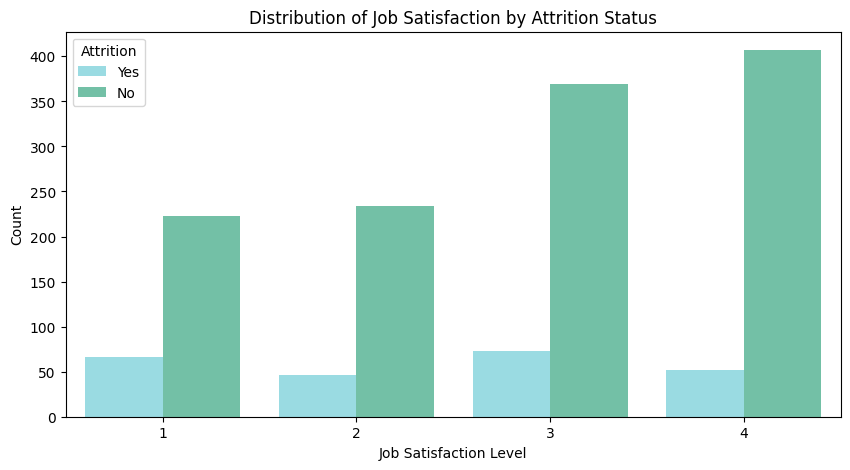

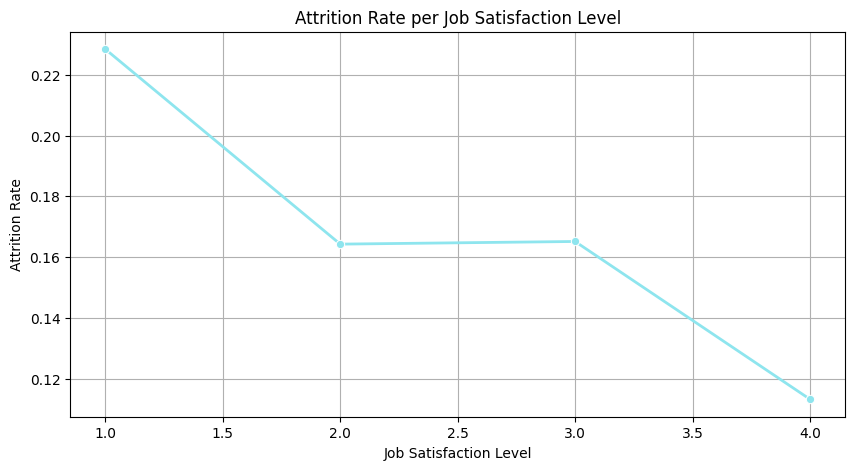

In [33]:
# Distribution of JobSatisfaction, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="JobSatisfaction", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of Job Satisfaction by Attrition Status")
plt.xlabel("Job Satisfaction Level")
plt.ylabel("Count")
plt.show()

# Distribution of Attrition Rate per JobSatisfaction
job_satisfaction_attrition = temp_df.groupby('JobSatisfaction')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=job_satisfaction_attrition.index, y=job_satisfaction_attrition.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per Job Satisfaction Level')
plt.xlabel('Job Satisfaction Level')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()

1. The first chart shows that  similar to environment satisfaction employees with a satisfaction level of 3 and 4 make up the majority, with about 400 employees each, while those with lower satisfaction levels (1 and 2) have smaller counts.

2. The attrition rate plot highlights that employees with the lowest job satisfaction (level 1) face an attrition rate of around 22%, which declines to about 12% for those with the highest satisfaction.

#### OverTime

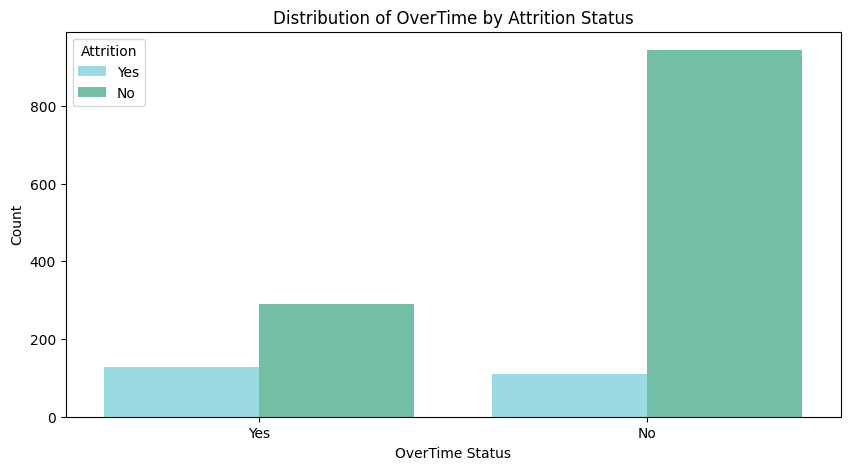

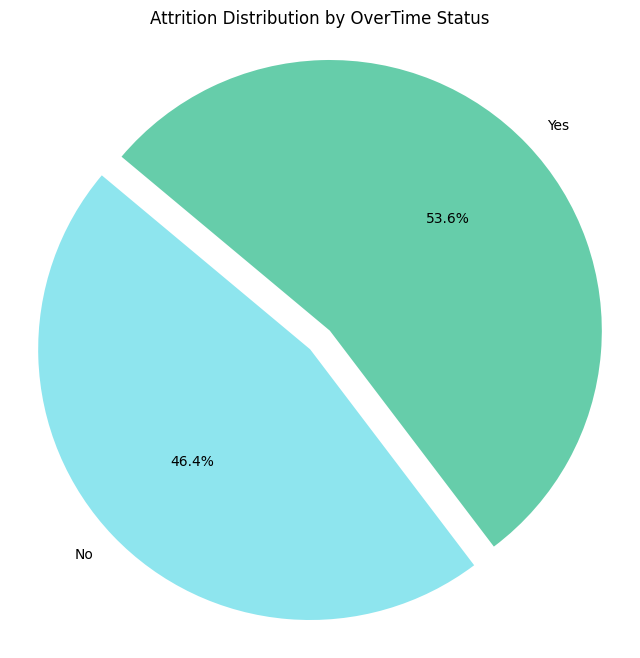

In [34]:
# Distribution of OverTime, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="OverTime", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of OverTime by Attrition Status")
plt.xlabel("OverTime Status")
plt.ylabel("Count")
plt.show()

# Distribution of Attrition Rate per OverTime (Pie Chart)
overtime_attrition_counts = temp_df.groupby('OverTime')['Attrition'].sum()
plt.figure(figsize=(8, 8))
colors = ['#8EE5EE', '#66CDAA']
plt.pie(overtime_attrition_counts, labels=overtime_attrition_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=(0.1, 0))
plt.title('Attrition Distribution by OverTime Status')
plt.axis('equal')
plt.show()

1. The bar chart shows the distribution of overtime work and attrition. The majority of employees, over 800, do not work overtime, while approximately 300 do.

2. The pie chart shows that employees working overtime have an attrition rate of 53.6%, while those who do not have a lower attrition rate of 46.4%.

#### WorkLifeBalance

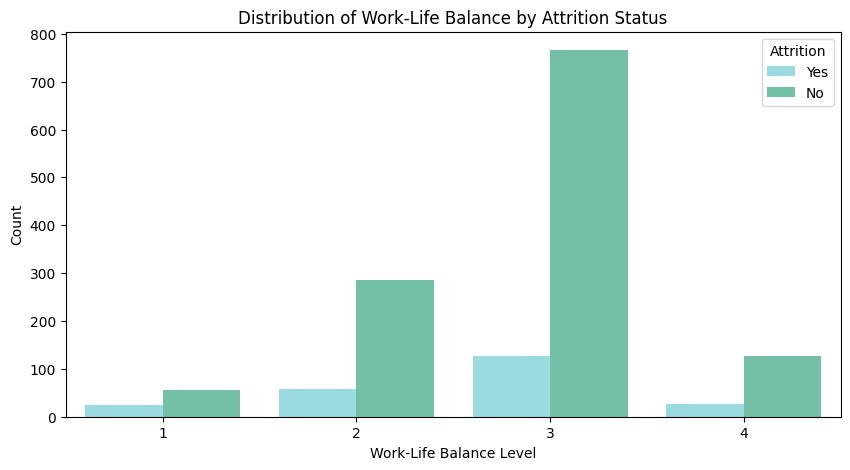

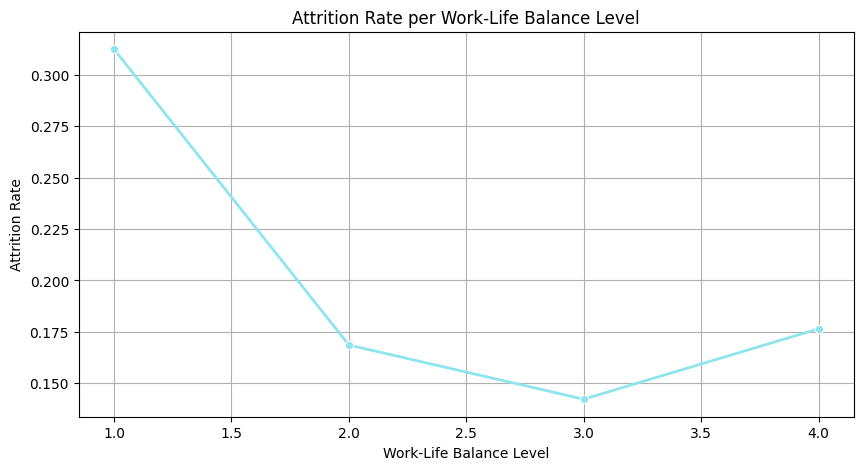

In [35]:
# Distribution of WorkLifeBalance, compared by Attrition
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="WorkLifeBalance", hue="Attrition", palette=['#8EE5EE',"#66CDAA"])
plt.title("Distribution of Work-Life Balance by Attrition Status")
plt.xlabel("Work-Life Balance Level")
plt.ylabel("Count")
plt.show()

# Distribution of Attrition Rate per WorkLifeBalance
worklife_balance_attrition = temp_df.groupby('WorkLifeBalance')['Attrition'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=worklife_balance_attrition.index, y=worklife_balance_attrition.values, marker='o', color='#8EE5EE', linewidth=2)
plt.title('Attrition Rate per Work-Life Balance Level')
plt.xlabel('Work-Life Balance Level')
plt.ylabel('Attrition Rate')
plt.grid(True)
plt.show()


1. The first chart presents work-life balance levels, where most employees report a balance level of 3, with around 750 employees, followed by level 2 with about 300 employees.

2. The attrition rate plot shows that employees with the lowest work-life balance (level 1) have the highest attrition rate at around 30%, while those with a balance level of 3 experience the lowest attrition rate, at about 15%, with a slight increase at level 4.


#### Summary of Feature Impact on Attrition:

**High Impact:**
- Environment Satisfaction
- Job Satisfaction
- Overtime

**Moderate to High Impact:**
- Work-Life Balance
- Business Travel

# 4. Data Preparation


## 4.1 Different types of distributions:

| **High Impact**                     | **Moderate to High**       | **Moderate Impact**                                                | **Low Impact**             |
|-------------------------------------|---------------------------|-------------------------------------------------------------------|----------------------------|
| Age                                 | Work-Life Balance          | Education                                                         | Gender                     |
| MaritalStatus                       | Business Travel            | EducationField                                                    | PerformanceRating          |
| JobRole                             |                           | TotalWorkingYears                                                 | StandardHours              |
| JobLevel                            |                           | YearsInCurrentRole                                                 |                            |
| JobInvolvement                      |                           | YearsWithCurrManager                                               |                            |
| Department                          |                           | TrainingTimesLastYear                                              |                            |
| MonthlyIncome                       |                           | NumCompaniesWorked                                                 |                            |
| EnvironmentalSatisfaction           |                           | MonthlyRate                                                        |                            |
| JobSatisfaction                     |                           | PercentSalaryHike                                                  |                            |
| OverTime                            |                           | RelationshipStatus                                                 |                            |
|                                     |                           | YearsSinceLastPromotion                                            |                            |


## 4.2 Correlation Matrix

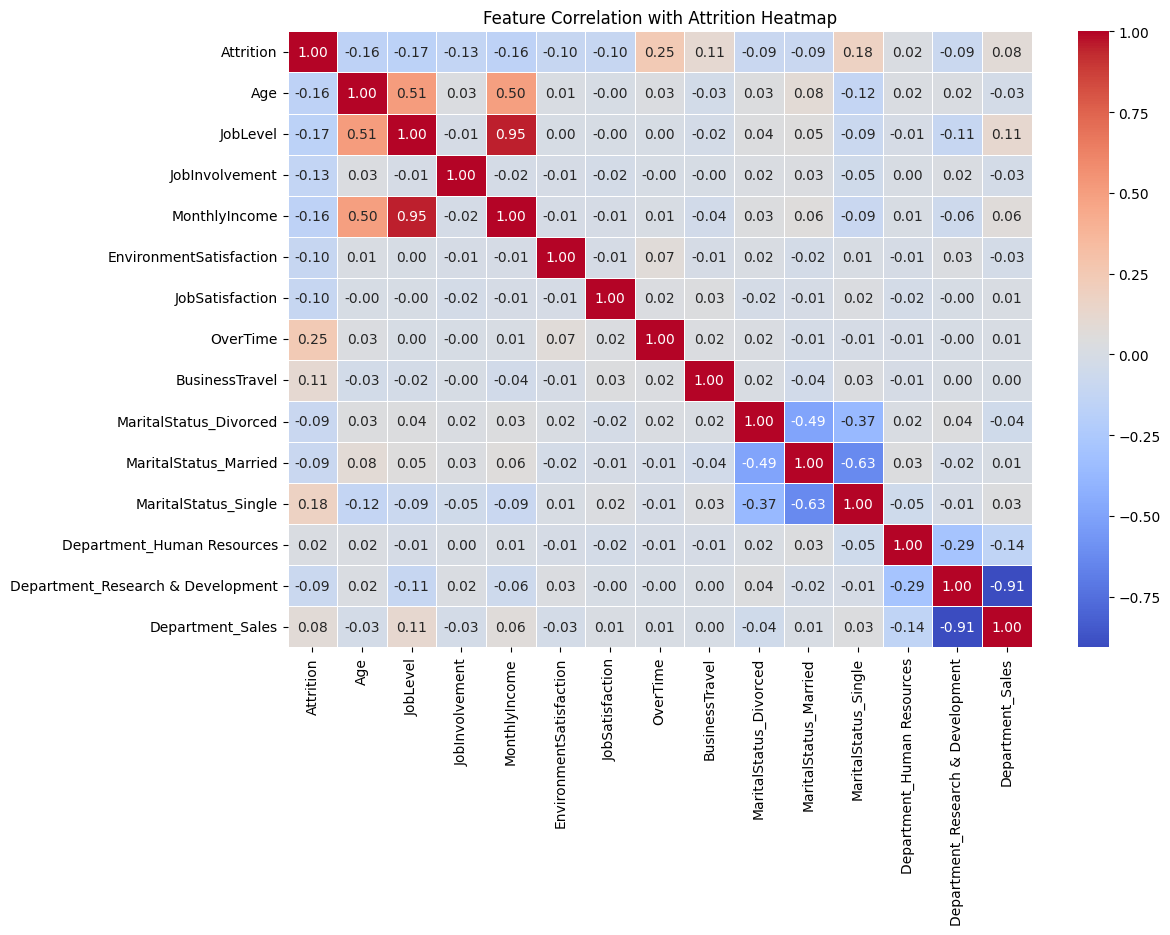

In [36]:
# Convert categorical 'Attrition' to numerical (Yes=1, No=0)
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})
df['BusinessTravel'] = df['BusinessTravel'].map({'Travel_Frequently': 2,'Travel_Rarely': 1, 'Non-travel': 0})

# Define the features including Attrition
high_impact_features = [
    'Attrition','Age', 'MaritalStatus',
    'JobLevel', 'JobInvolvement', 'Department',
    'MonthlyIncome', 'EnvironmentSatisfaction', 'JobSatisfaction', 'OverTime', 'BusinessTravel'

]

# Convert categorical features to numerical values
df_encoded = pd.get_dummies(df[high_impact_features])

# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()


plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)


plt.title("Feature Correlation with Attrition Heatmap")
plt.show()


- OverTime (0.25) shows the strongest positive correlation with attrition, indicating that employees who work overtime are more likely to leave

- JobLevel (-0.17), Age (-0.16), and MonthlyIncome (-0.16) have negative correlations with attrition, suggesting that older employees, those in higher job levels, and those earning more are less likely to leave

- MaritalStatus_Single (0.18) has a positive correlation with attrition, indicating that single employees are more prone to leaving compared to married or divorced employees

- Correlations for JobSatisfaction, EnvironmentSatisfaction, and BusinessTravel are relatively weak, meaning they may have minimal direct impact on attrition

- Department-wise, employees in Sales (0.08) show a slightly higher tendency to leave, while those in Research & Development (-0.09) are less likely to leave compared to other departments

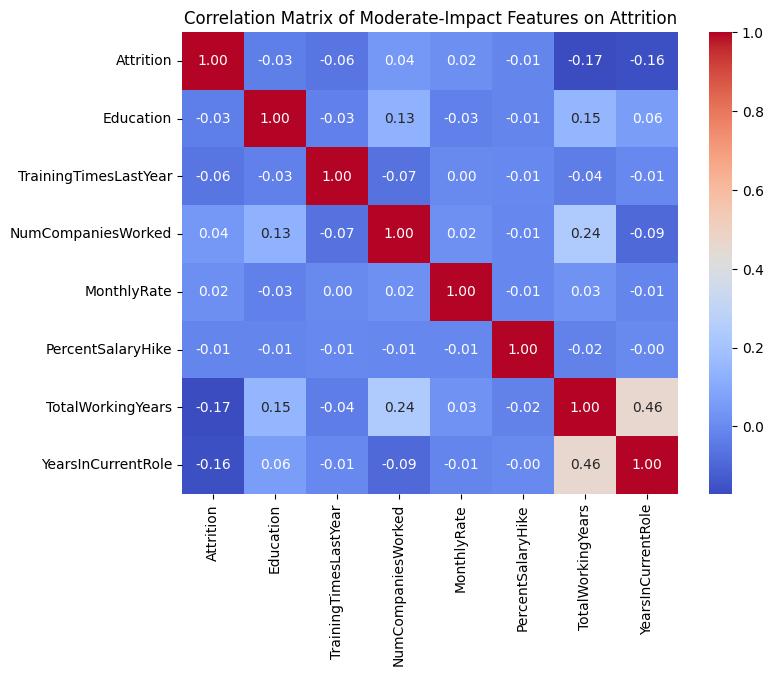

In [37]:
moderate_impact_features = [
    'Attrition', 'Education', 'TrainingTimesLastYear', 'NumCompaniesWorked', 'MonthlyRate', 'PercentSalaryHike', 'TotalWorkingYears', 'YearsInCurrentRole'
]

# Compute the correlation matrix
correlation_matrix = df[moderate_impact_features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Moderate-Impact Features on Attrition')
plt.show()

Even though this is the matrix of moderate-impact features, there are two which show a slightly higher value for correlation than the others.
- TotalWorkingYears (0.17) and YearsInCurrentRole (0.16) both show a positive correlation. That is why they can be taken into consideration as important for model building as well.

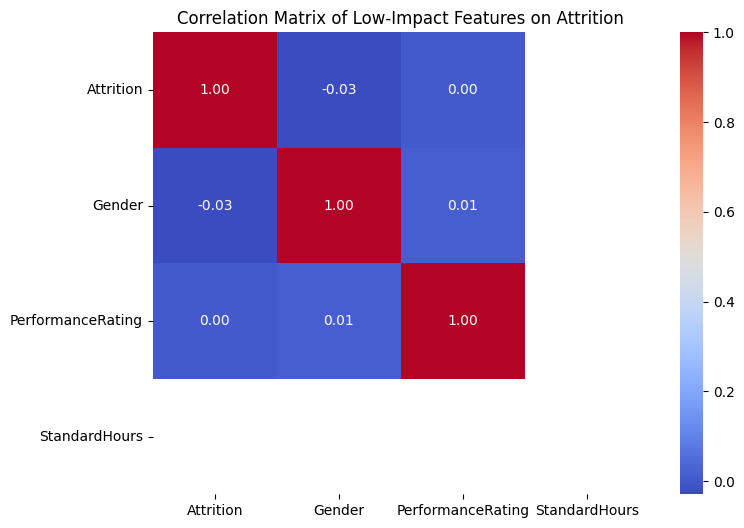

In [38]:
# Convert categorical features to numerical for correlation analysis
df['Gender'] = df['Gender'].map({'Female': 1, 'Male': 0})

low_impact_features = [
    'Attrition', 'Gender', 'PerformanceRating', 'StandardHours' ]

# Compute the correlation matrix
correlation_matrix = df[low_impact_features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Low-Impact Features on Attrition')
plt.show()

This correlation matrix shows the features that have the least impact on attrition which are Gender (-0.03), PerformanceRating (0) and StandardHours.  

## 4.3 Deleting Redundant Features

Features that are not needed for the next step of building a model can be defined as low-impact features. This categorization was made based on data visualizations. The values near to 0 of those features in the correlation matrix underline this. Therefore, the described features are not needed anymore and will be deleted in the following step. Furthermore, the features "HourlyRate" and "Over18" will be deleted as well. These two features were not visualized and further considered, due to the fact that the same realisation is probably achieved with "MonthlyRate" and „Age".

In [39]:
#Deleting features that are not needed
deletable_features = ['TotalWorkingYears', 'YearsInCurrentRole',
                      'Gender', 'PerformanceRating', 'StandardHours', 'HourlyRate', 'Over18', 'EmployeeCount', 'EmployeeNumber']
df = df.drop(columns=deletable_features)

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,1.0,1102,Sales,1,2,Life Sciences,2,3,2,Sales Executive,4,Single,5993,19479,8,1,11,1,0,0,1,6,0,5
1,49,0,2.0,279,Research & Development,8,1,Life Sciences,3,2,2,Research Scientist,2,Married,5130,24907,1,0,23,4,1,3,3,10,1,7
2,37,1,1.0,1373,Research & Development,2,2,Other,4,2,1,Laboratory Technician,3,Single,2090,2396,6,1,15,2,0,3,3,0,0,0
3,33,0,2.0,1392,Research & Development,3,4,Life Sciences,4,3,1,Research Scientist,3,Married,2909,23159,1,1,11,3,0,3,3,8,3,0
4,27,0,1.0,591,Research & Development,2,1,Medical,1,3,1,Laboratory Technician,2,Married,3468,16632,9,0,12,4,1,3,3,2,2,2


## 4.4 Transformed Data and New Features



In [40]:
# Define bins and labels for MonthlyRate
monthly_rate_bins = [2000, 8000, 14000, 20000, 26000, 30000]
monthly_rate_labels = ['2000-8000', '8001-14000', '14001-20000', '20001-26000', '26001-30000']
df['MonthlyRateCategory'] = pd.cut(df['MonthlyRate'], bins=monthly_rate_bins, labels=monthly_rate_labels, right=False)

# Define bins and labels for MonthlyIncome
monthly_income_bins = [1000, 5000, 10000, 15000, 20000]
monthly_income_labels = ['1000-5000', '5001-10000', '10001-15000', '15001-20000']
df['MonthlyIncomeCategory'] = pd.cut(df['MonthlyIncome'], bins=monthly_income_bins, labels=monthly_income_labels, right=False)

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,MonthlyRateCategory,MonthlyIncomeCategory
0,41,1,1.0,1102,Sales,1,2,Life Sciences,2,3,2,Sales Executive,4,Single,5993,19479,8,1,11,1,0,0,1,6,0,5,14001-20000,5001-10000
1,49,0,2.0,279,Research & Development,8,1,Life Sciences,3,2,2,Research Scientist,2,Married,5130,24907,1,0,23,4,1,3,3,10,1,7,20001-26000,5001-10000
2,37,1,1.0,1373,Research & Development,2,2,Other,4,2,1,Laboratory Technician,3,Single,2090,2396,6,1,15,2,0,3,3,0,0,0,2000-8000,1000-5000
3,33,0,2.0,1392,Research & Development,3,4,Life Sciences,4,3,1,Research Scientist,3,Married,2909,23159,1,1,11,3,0,3,3,8,3,0,20001-26000,1000-5000
4,27,0,1.0,591,Research & Development,2,1,Medical,1,3,1,Laboratory Technician,2,Married,3468,16632,9,0,12,4,1,3,3,2,2,2,14001-20000,1000-5000


Here we added new features called MonthlyRateCategory and MonthlyIncomeCategory. This transformation improved visualization clarity by making trends more apparent. 

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       1470 non-null   int64   
 1   Attrition                 1470 non-null   int64   
 2   BusinessTravel            1320 non-null   float64 
 3   DailyRate                 1470 non-null   int64   
 4   Department                1470 non-null   object  
 5   DistanceFromHome          1470 non-null   int64   
 6   Education                 1470 non-null   int64   
 7   EducationField            1470 non-null   object  
 8   EnvironmentSatisfaction   1470 non-null   int64   
 9   JobInvolvement            1470 non-null   int64   
 10  JobLevel                  1470 non-null   int64   
 11  JobRole                   1470 non-null   object  
 12  JobSatisfaction           1470 non-null   int64   
 13  MaritalStatus             1470 non-null   object

We also transformed some of the features of the dataset were for easier analyzation. Categorical values such as Attrition, OverTime or BusinessTravel were converted into numbers (e.g "Yes" became 1 and "No" became 0).



In [42]:
df.isna().sum()

Age                           0
Attrition                     0
BusinessTravel              150
DailyRate                     0
Department                    0
DistanceFromHome              0
Education                     0
EducationField                0
EnvironmentSatisfaction       0
JobInvolvement                0
JobLevel                      0
JobRole                       0
JobSatisfaction               0
MaritalStatus                 0
MonthlyIncome                 0
MonthlyRate                   0
NumCompaniesWorked            0
OverTime                      0
PercentSalaryHike             0
RelationshipSatisfaction      0
StockOptionLevel              0
TrainingTimesLastYear         0
WorkLifeBalance               0
YearsAtCompany                0
YearsSinceLastPromotion       0
YearsWithCurrManager          0
MonthlyRateCategory           0
MonthlyIncomeCategory         0
dtype: int64

In [43]:
df['BusinessTravel'].fillna(df['BusinessTravel'].mode()[0], inplace=True)

We decided to retain the data by imputing the missing values in the BusinessTravel column using the most frequent category. This approach ensures that we preserve the overall dataset size, preventing potential data loss that could impact our analysis. Since BusinessTravel has a relatively weak correlation with attrition, imputing the missing values is unlikely to introduce significant bias while maintaining data consistency for further analysis.

In [44]:
df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
RelationshipSatisfaction    0
StockOptionLevel            0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
MonthlyRateCategory         0
MonthlyIncomeCategory       0
dtype: int64

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       1470 non-null   int64   
 1   Attrition                 1470 non-null   int64   
 2   BusinessTravel            1470 non-null   float64 
 3   DailyRate                 1470 non-null   int64   
 4   Department                1470 non-null   object  
 5   DistanceFromHome          1470 non-null   int64   
 6   Education                 1470 non-null   int64   
 7   EducationField            1470 non-null   object  
 8   EnvironmentSatisfaction   1470 non-null   int64   
 9   JobInvolvement            1470 non-null   int64   
 10  JobLevel                  1470 non-null   int64   
 11  JobRole                   1470 non-null   object  
 12  JobSatisfaction           1470 non-null   int64   
 13  MaritalStatus             1470 non-null   object

## 4.5 Splitting Data

In [46]:
# Define target variable and features
X = df.drop(columns=['Attrition'])  
y = df['Attrition']

# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Print dataset sizes
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (1176, 27), Test set: (294, 27)


## 4.6 Pre-processing Pipelines

In [47]:
# Define categorical and numerical features
categorical_features = [
    "BusinessTravel", "Department", "EducationField", "JobRole", "MaritalStatus", 
    "MonthlyRateCategory", "MonthlyIncomeCategory", "Education", "EnvironmentSatisfaction", 
    "JobInvolvement", "JobLevel", "JobSatisfaction", "RelationshipSatisfaction",
    "StockOptionLevel", "WorkLifeBalance"
]

numerical_features = [
    "Age", "DailyRate", "DistanceFromHome", "MonthlyIncome", "MonthlyRate", "NumCompaniesWorked", 
    "OverTime", "PercentSalaryHike", "TrainingTimesLastYear", "YearsAtCompany", 
    "YearsSinceLastPromotion", "YearsWithCurrManager"
]

# Preprocessing steps
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer([
    ("num", Pipeline([("imputer", imputer), ("scaler", scaler)]), numerical_features),
    ("cat", encoder, categorical_features)
])

# 5. Model Random Forest

When predicting employee attrition, Random Forest could be a reliable choice because it builds multiple decision trees on different data subsets and averages their predictions. This approach helps reduce overfitting, where a model learns too much from training data, including noise, and fails to generalize to new data. 

In [48]:
# Create model
forest = RandomForestClassifier(class_weight='balanced',random_state=42)

# Create pipeline for preprocessing and model training
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", forest)
])

## 5.1 Hyperparameter Tuning

Hyperparameters are defined and tuned to ensure that the model achieves the best possible accuracy in its predictions. They control how the model learns from the data, such as determining how deep a decision tree should grow or how many samples are required to split a node. If these parameters are set too strictly, important patterns may be missed (underfitting), while overly flexible settings can lead to the model memorizing the data too well (overfitting.

In [49]:
# Define hyperparameter grid for tuning
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 4, 10]
}

# Perform hyperparameter tuning
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


## 5.2 Model Evaluation

### 5.2.1 Confusion Matrix

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       247
           1       0.37      0.40      0.39        47

    accuracy                           0.80       294
   macro avg       0.63      0.64      0.63       294
weighted avg       0.80      0.80      0.80       294



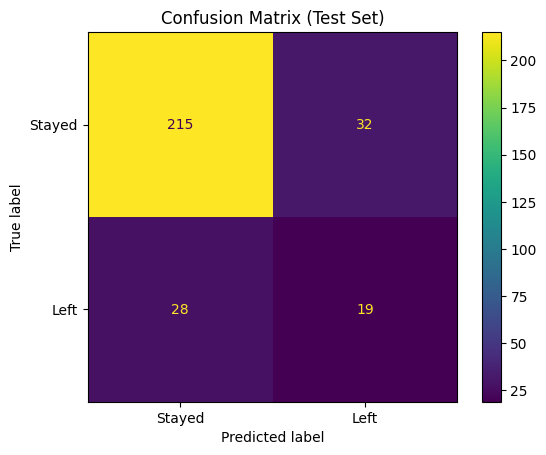

In [50]:
# Evaluate the model on the test set
y_test_pred = grid_search.best_estimator_.predict(X_test)

print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix visualization
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Stayed', 'Left'])
disp_test.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix (Test Set)')
plt.show()


**Performance Metrics:**
- Precision (Stayed): 0.88 – Out of all predicted as "Stayed," 88% were correct
- Recall (Stayed): 0.87 – 87% of actual "Stayed" employees were identified correctly
- Precision (Left): 0.37 – Only 37% of predicted "Left" were correct
- Recall (Left): 0.40 – 40% of employees who left were correctly classified
- Accuracy: 80%

**Confusion Matrix Interpretation:**

- True Positives (Stayed): 215 correctly classified employees who stayed
- False Positives (Stayed but predicted as Left): 32 instances
- False Negatives (Left but predicted as Stayed): 28 instances
- True Positives (Left): 19 correctly classified employees who left

### 5.2.2 Feature Importance

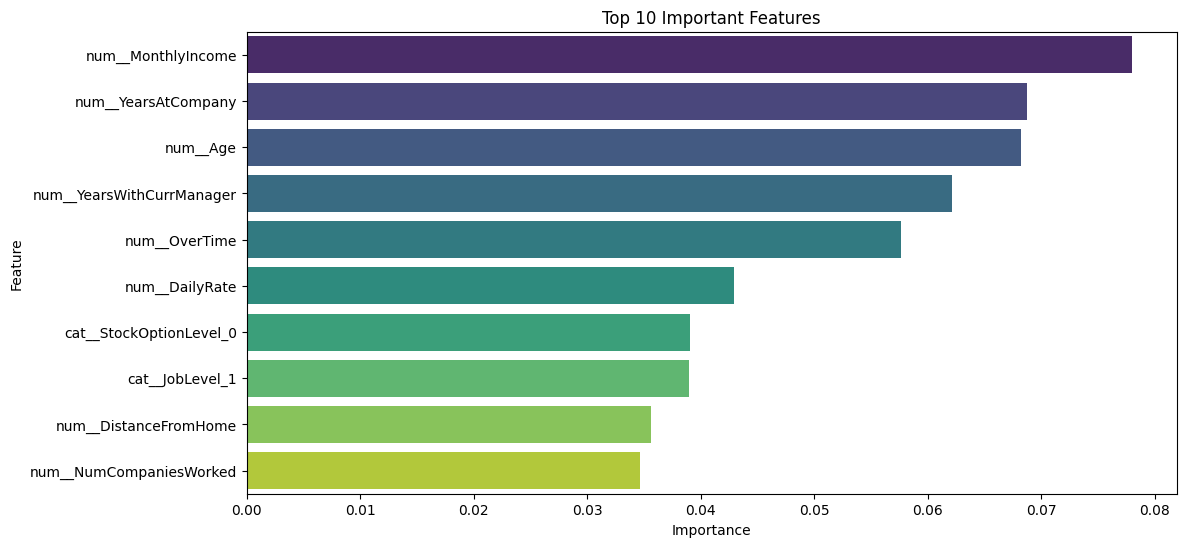

In [51]:
# Feature importance analysis
feature_importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df[:10], palette='viridis')
plt.title('Top 10 Important Features')
plt.show()


**The most influential features in the model are:**

- MonthlyIncome
    - Higher importance indicates a strong correlation between income and attrition
- YearsAtCompany 
    - Employees with longer tenure tend to stay longer
- Age
    - Older employees may have different retention patterns
- YearsWithCurrManager
    - The length of time an employee has been with their current manager has a significant impact on attrition
- OverTime
    - Whether an employee does overtime may impact attrition

# 6. Model Decision Tree

Decision Trees are simple and interpretable models but tend to overfit, meaning they might focus too much on specific details in the training set and perform poorly on unseen data. While Random Forest offers better accuracy and robustness, Decision Trees are useful when quick and clear insights are needed.

In [52]:
# Create DecisionTree
tree = DecisionTreeClassifier(class_weight='balanced',random_state=42)

# Create pipeline for preprocessing and model training
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", tree)
])


## 6.1 Hyperparameter Tuning

In [53]:
# Define hyperparameter grid for tuning
param_grid = {
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 4, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# Perform hyperparameter tuning
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}


## 6.2 Model Evaluation

### 6.1.1 Confusion Matrix

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       247
           1       0.28      0.51      0.36        47

    accuracy                           0.71       294
   macro avg       0.58      0.63      0.59       294
weighted avg       0.79      0.71      0.74       294



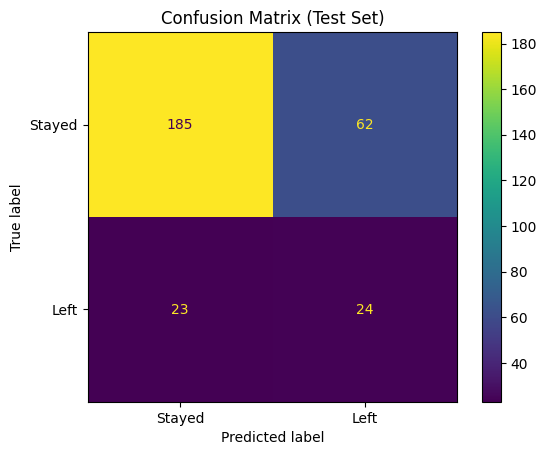

In [54]:
# Evaluate the model on the test set
y_test_pred = grid_search.best_estimator_.predict(X_test)

print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix visualization
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Stayed', 'Left'])
disp_test.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix (Test Set)')
plt.show()

**Performance Metrics:**
- Precision for Stayed (0): 0.89 – 89% of predicted “Stayed” were correct
- Recall for Stayed (0): 0.75 – The model correctly identified 75% of actual “Stayed” employees
- Precision for Left (1): 0.28 – Only 28% of employees predicted to leave actually did
- Recall for Left (1): 0.51 – 51% of employees who left were identified correctly
- Overall Accuracy: 71%

**Confusion Matrix:**
- True Positives (Left): 24 employees who actually left were correctly predicted
- False Positives (Stayed but predicted as Left): 62 employees incorrectly predicted as leaving
- False Negatives (Left but predicted as Stayed): 23 employees who left were misclassified as staying
- True Negatives (Stayed): 185 employees who stayed were correctly classified


### 6.1.2 Feature Importance

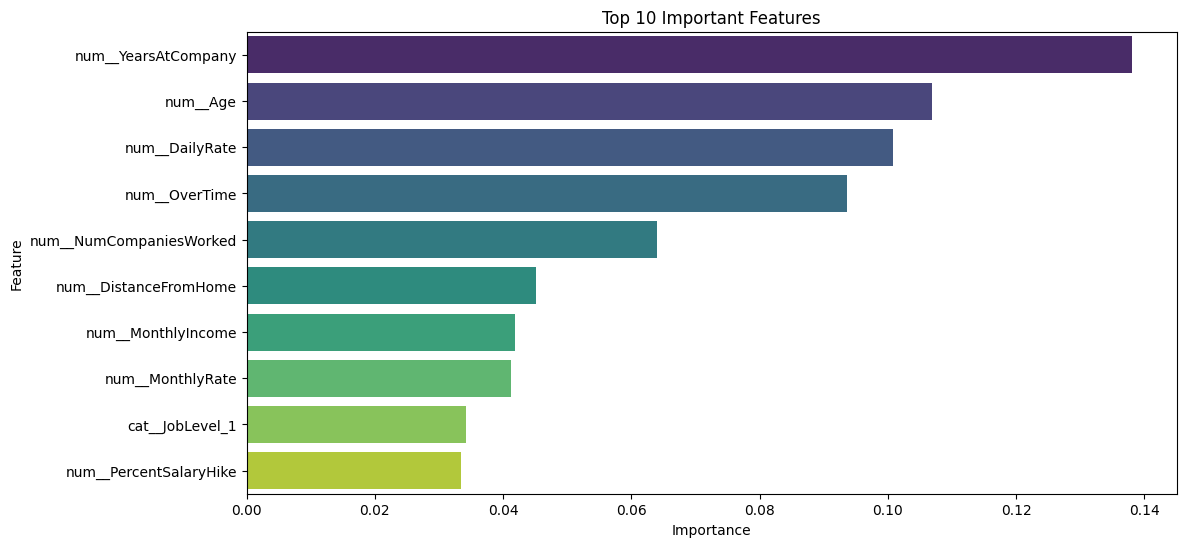

In [55]:
# Feature importance analysis
feature_importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df[:10], palette='viridis')
plt.title('Top 10 Important Features')
plt.show()

# 7. Comparison and Conclusion

## 7.1 Model Comparison

| Metric               | Decision Tree | Random Forest |
|---------------------|---------------|---------------|
| Accuracy             | 71%            | 80%            |
| Precision (Left)     | 28%            | 37%            |
| Recall (Left)        | 51%            | 40%            |
| False Positives      | 62             | 32             |
| False Negatives      | 23             | 28             |




**Accuracy:**
- Measures the percentage of correct predictions (both stayed and left) out of all predictions made by the model
- Random Forest (80%) outperforms Decision Tree (71%), meaning it makes fewer overall mistakes
- A higher accuracy suggests that Random Forest is generally better at classifying employees correctly

> **Random Forest provides better overall classification accuracy**

**Precision of "Left" or Attrition:**
- Percentage of employees predicted to leave who actually left (True Positives / (True Positives + False Positives))
- Random Forest (37%) has better precision than Decision Tree (28%)
- Random Forest makes fewer false alarms when predicting attrition, while Decision Tree is more prone to wrongly classifying employees as leaving when they actually stay

> **If minimizing false alarms (false positives) is important, Random Forest is the better choice**

**Recall of "Left":** 
- Measures the percentage of employees who actually left and were correctly identified by the model (True Positives / (True Positives + False Negatives))
- Decision Tree (51%) has better recall than Random Forest (40%)
- Decision Tree is better at catching employees who are likely to leave, even if it comes at the cost of more false positives

> **If identifying all potential attrition cases is more important (even with some false positives), Decision Tree is the better choice**

**False Positives:**
- Occur when the model incorrectly predicts an employee will leave when they actually stay
- Decision Tree (62 false positives) is higher compared to Random Forest (32 false positives)
- Decision Tree tends to overestimate attrition risk
  
> **If a high number of false positives would cause unnecessary interventions, Random Forest should be preferred**

**False Negatives:**
- Occur when the model fails to predict an employee who will leave (i.e., incorrectly predicting they will stay)
- Decision Tree (23 false negatives) is slightly better than Random Forest (28 false negatives)
- Decision Tree is better at catching employees who actually left, whereas Random Forest misses more cases

> **Decision Tree might be better for cases where missing a potential attrition case is costly**

## 7.2 Conclusion

For predicting valuable employees likely to leave, Random Forest is the better choice because it provides higher accuracy (80%) and precision (37%) compared to Decision Tree. It reduces false positives, making sure that HR focuses on employees who are actually at risk while also minimizing unnecessary interventions. Although Decision Tree has better recall, it leads to more false alarms, making Random Forest the more reliable option.

# 8. Possible Business Use

The builded model can help a business to identify future attrition. To be concrete, businesses can identify which employees may be wanting to leave their position soon. This creates a better overview for human resources in the business.
The gained knowledge can be used to act differently. On the one hand, businesses can try to keep the company attractive specifically for those groups of people who are more likely to leave the company soon. Also conversations can be held with these employees to further specify their needs and to react to them. This way, businesses can achieve to reduce attrition and therefore reduce resources to find new employees and to onboard them. This can help a business to be more efficient.
On the other hand, businesses can use the gained knowledge to be prepared for possible attrition and to stay flexible, so that positions can be reoccupied in a fast process.